## 1. Environment Setup and Imports

We begin by importing essential libraries for data manipulation, statistical analysis, machine learning, and visualization.


In [71]:
import warnings
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import scipy.stats as stats

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


from src.loader import load_raw_data
from src.preprocessing import run_full_preprocessing
import src.config as config

plots_dir = project_root / "plots"
plots_dir.mkdir(exist_ok=True)

# Configure display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Visualization settings
# 1. Apply the base style
plt.style.use("seaborn-v0_8-darkgrid")

# 2. Set global parameters
plt.rcParams.update({
    "grid.alpha": 0.4,
    "axes.axisbelow": True       
})

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("✓ Environment configured successfully")
print(f"✓ Data directory: {config.DATA_DIR}")
%reload_ext autoreload
%autoreload 2


✓ Environment configured successfully
✓ Data directory: C:\Users\Nikita\dev\the\data\raw


## 2. Data Loading and Validation

We utilize the custom data loading pipeline to integrate multiple NHANES data files and apply comprehensive preprocessing.


In [72]:
df_raw = pd.read_csv(project_root / "data/processed/processed_data.csv")

print("\n Data loaded successfully:")
print(f"  Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"  Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

df_processed = run_full_preprocessing(df_raw)

print("\n✓ Preprocessing completed successfully")
print(
    f"  Final shape: {df_processed.shape[0]:,} rows × {df_processed.shape[1]} columns"
)
print(f"  Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic validation checks
print("\n" + "=" * 80)
print("DATA VALIDATION CHECKS")
print("=" * 80)

# Check for target variables
assert "PHQ9_Score" in df_processed.columns, "PHQ9_Score not found in processed data"
assert "Depression" in df_processed.columns, "Depression not found in processed data"

# Check for missing values in targets
missing_targets = df_processed[["PHQ9_Score", "Depression"]].isnull().sum()
print(f"\nMissing values in target variables:")
print(f"  PHQ9_Score: {missing_targets['PHQ9_Score']}")
print(f"  Depression: {missing_targets['Depression']}")

# Check data types
print(f"\nData types:")
print(df_processed.dtypes.value_counts())

print("\n✓ Data loading and validation complete")



 Data loaded successfully:
  Shape: 20,369 rows × 107 columns
  Memory usage: 16.63 MB
Starting Preprocessing Pipeline...
-> Processing Dietary Data: Averaging Day 1 and Day 2...
-> Imputation Complete. Final Shape: (20369, 133)
-> Feature Engineering: Calculated CDAI
-> Feature Engineering: Calculated DII using 26 components.
-> Cleanup: Dropped 26 dietary component columns as requested.
-> Feature Engineering: Calculated Metabolic Score indices
-> Feature Engineering: Calculated eGFR

✓ Preprocessing completed successfully
  Final shape: 20,369 rows × 107 columns
  Memory usage: 16.63 MB

DATA VALIDATION CHECKS

Missing values in target variables:
  PHQ9_Score: 0
  Depression: 0

Data types:
float64    105
int64        2
Name: count, dtype: int64

✓ Data loading and validation complete


## 3. Basic Dataset Overview

We examine the structure and basic characteristics of the processed dataset, including target variable distribution.


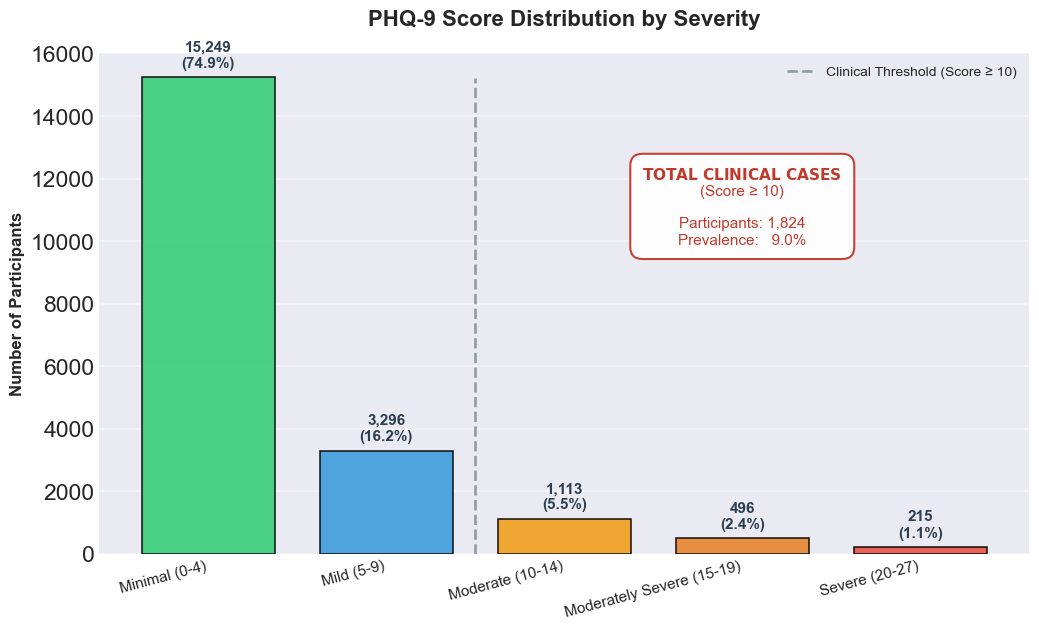

In [73]:
def plot_phq9_final_no_arrow(df):
    # Set font settings (optional, ensures clean rendering)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(12, 6.5))

    # 1. Define PHQ-9 Severity Categories
    # Bins correspond to standard PHQ-9 cutoffs: 0-4, 5-9, 10-14, 15-19, 20-27
    df_viz = df.copy()
    df_viz["PHQ9_Category"] = pd.cut(
        df["PHQ9_Score"],
        bins=[-1, 4, 9, 14, 19, 27],
        labels=[
            "Minimal (0-4)",
            "Mild (5-9)",
            "Moderate (10-14)",
            "Moderately Severe (15-19)",
            "Severe (20-27)",
        ],
    )

    # Calculate counts and percentages
    category_counts = df_viz["PHQ9_Category"].value_counts().sort_index()
    category_pct = (category_counts / len(df_viz) * 100).round(1)

    # 2. Color Palette (Using the bright "Old Palette" as requested)
    # Green -> Blue -> Yellow -> Orange -> Red
    colors_palette = ["#2ecc71", "#3498db", "#f39c12", "#e67e22", "#e74c3c"]

    # 3. Draw Bar Chart
    bars = ax.bar(
        range(len(category_counts)),
        category_counts.values,
        color=colors_palette,
        alpha=0.85,  # Slight transparency
        edgecolor="black",  # Black border for contrast
        linewidth=1.2,
        width=0.75,
        zorder=3,
    )

    # 4. Add Value Labels on top of bars
    for bar, count, pct in zip(bars, category_counts.values, category_pct.values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + (max(category_counts.values) * 0.015),  # Dynamic offset
            f"{count:,}\n({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
            color="#2c3e50",
        )

    # 5. Add Clinical Threshold Line (Vertical)
    ax.axvline(
        x=1.5,
        ymin=0,
        ymax=0.95,
        color="#7f8c8d",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label="Clinical Threshold (Score ≥ 10)",
        zorder=2,
    )

    # 6. Calculate Clinical Totals (Sum of Moderate, Mod-Severe, Severe)
    # Indices 2, 3, and 4 correspond to the clinical categories
    clinical_sum = category_counts.iloc[2:].sum()
    clinical_pct_sum = category_pct.iloc[2:].sum()

    # Formulate the annotation text
    text_str = (
        f"$\\bf{{TOTAL\\ CLINICAL\\ CASES}}$\n"  # LaTeX for bold title
        f"(Score ≥ 10)\n\n"
        f"Participants: {clinical_sum:,}\n"
        f"Prevalence:   {clinical_pct_sum:.1f}%"
    )

    # 7. Add Annotation Box (Floating, without arrow)
    # Centered roughly over the clinical section (indices 2, 3, 4)
    ax.text(
        x=3.0,  # Horizontal position: Centered around the "Moderately Severe" bar
        y=max(category_counts.values) * 0.65,  # Vertical position
        s=text_str,
        ha="center",
        fontsize=11,
        color="#c0392b",  # Dark red text
        bbox=dict(
            boxstyle="round,pad=0.8",
            fc="white",  # White background
            ec="#c0392b",  # Red border
            alpha=0.95,
            lw=1.5,
        ),
    )

    # 8. Final Styling (Clean Look)
    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # Light gray for remaining spines
    ax.spines["left"].set_color("#cfd8dc")
    ax.spines["bottom"].set_color("#cfd8dc")

    # X-axis labels formatting
    ax.set_xticks(range(len(category_counts)))
    ax.set_xticklabels(category_counts.index, rotation=15, ha="right", fontsize=11)

    # Titles and Labels
    ax.set_ylabel("Number of Participants", fontsize=12, fontweight="bold")
    ax.set_title(
        "PHQ-9 Score Distribution by Severity", fontsize=16, fontweight="bold", pad=20
    )

    # Legend
    ax.legend(loc="upper right", frameon=False, fontsize=10)

    # Layout adjustment and saving

    plt.savefig(plots_dir / "depression.png", dpi=300, bbox_inches="tight")
    plt.show()


# Execute the function (assuming df_processed is loaded)
plot_phq9_final_no_arrow(df_processed)

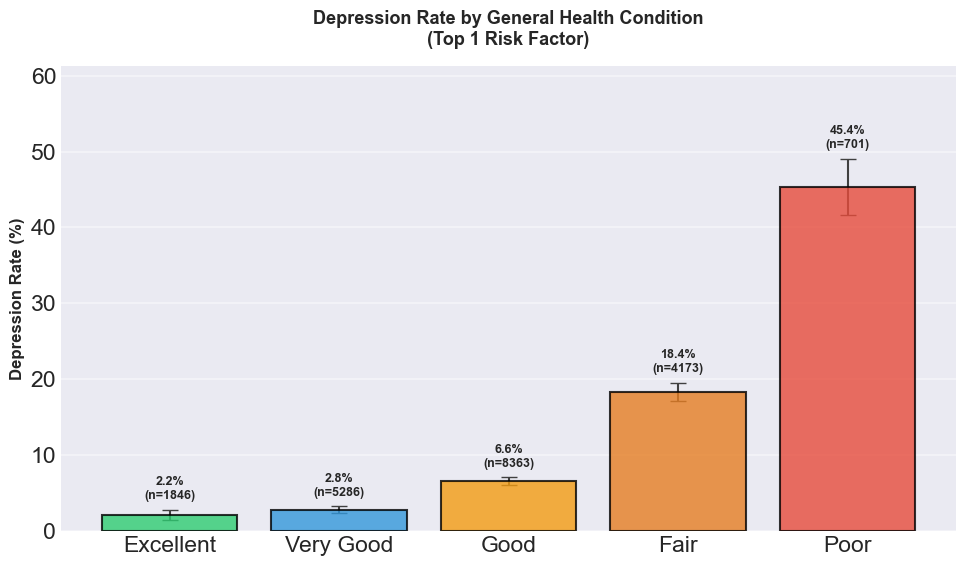

✓ Feature 1: General Health Condition


In [74]:
df_viz = df_processed.copy()
df_plot = df_viz[["General_Health_Cond", "Depression"]].dropna()

# Health condition labels
health_labels = {1: "Excellent", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}

# Create bar chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Bar chart
health_depression = (
    df_plot.groupby("General_Health_Cond")
    .agg({"Depression": ["mean", "count"]})
    .reset_index()
)
health_depression.columns = ["General_Health_Cond", "Depression_Rate", "Count"]
health_depression["Health_Label"] = health_depression["General_Health_Cond"].map(
    health_labels
)

# Calculate 95% Confidence Intervals for proportions
# CI = 1.96 * sqrt(p*(1-p)/n)
import numpy as np

health_depression["CI_95"] = (
    1.96
    * np.sqrt(
        health_depression["Depression_Rate"]
        * (1 - health_depression["Depression_Rate"])
        / health_depression["Count"]
    )
    * 100
)  # Convert to percentage

colors = ["#2ecc71", "#3498db", "#f39c12", "#e67e22", "#e74c3c"]
bars = ax.bar(
    range(len(health_depression)),
    health_depression["Depression_Rate"] * 100,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
    zorder=2,  # Ensure bars are above error bars
)

# Add error bars with 95% CI
ax.errorbar(
    range(len(health_depression)),
    health_depression["Depression_Rate"] * 100,
    yerr=health_depression["CI_95"],
    fmt="none",
    capsize=6,
    color="#404040",
    linewidth=1.5,
    zorder=1,  # Error bars behind bars
)

ax.set_xticks(range(len(health_depression)))
ax.set_xticklabels(health_depression["Health_Label"], rotation=0, ha="center")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Depression Rate by General Health Condition\n(Top 1 Risk Factor)",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

# Increase y-axis limit to accommodate error bars and labels
max_value = (
    health_depression["Depression_Rate"] * 100 + health_depression["CI_95"]
).max()
ax.set_ylim(0, max_value * 1.25)  # Add 25% padding for labels above error bars

# Add value labels (zorder=3 to ensure they're on top)
for i, (bar, count, rate) in enumerate(
    zip(bars, health_depression["Count"], health_depression["Depression_Rate"])
):
    height = bar.get_height()
    error_value = health_depression["CI_95"].iloc[i]
    # Position text above the error bar: bar_height + error_value + small_padding
    text_y_position = (
        height + error_value + (max_value * 0.02)
    )  # 2% of max value as padding
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        text_y_position,
        f"{rate * 100:.1f}%\n(n={count})",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        zorder=3,  # Text labels on top
    )

plt.tight_layout()
plt.savefig(plots_dir / "general_Health_Cond.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Feature 1: General Health Condition")


### Feature 2: Marital Status


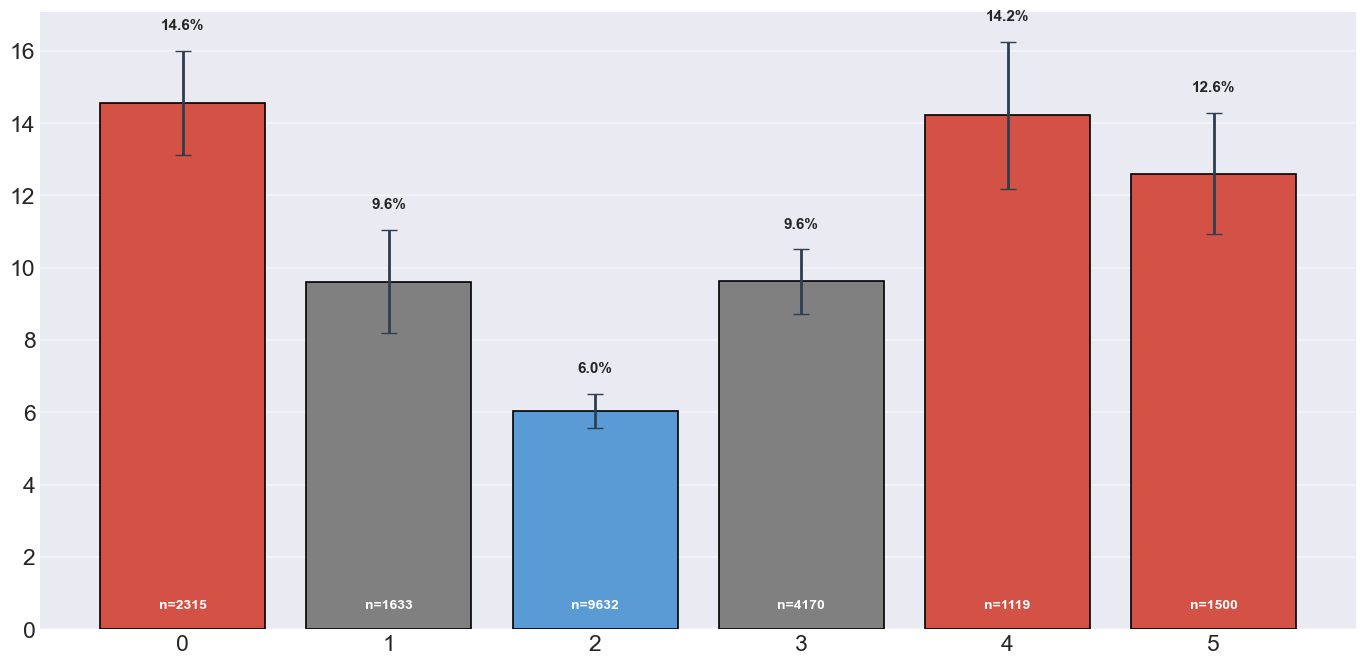

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==============================================================================
# VISUALIZATION: REAL MARITAL STATUS IMPACT
# ==============================================================================

# 1. Data Preparation from df_viz
# ------------------------------------------------------------------------------
marital_cols = ["Marital_Status", "Depression"]
df_marital = df_viz[marital_cols].dropna().copy()

# Filter out NHANES missing codes for Marital Status (77: Refused, 99: Don't know)
df_marital = df_marital[~df_marital["Marital_Status"].isin([77, 99])]

# Map numerical codes to human-readable labels
marital_labels = {
    1: "Married",
    2: "Widowed",
    3: "Divorced",
    4: "Separated",
    5: "Never Married",
    6: "Living with Partner",
}
df_marital["Marital_Label"] = df_marital["Marital_Status"].map(marital_labels)

# 2. Statistical Aggregation
# ------------------------------------------------------------------------------
# Calculate real rates and sample sizes
stats = (
    df_marital.groupby("Marital_Label", observed=False)
    .agg(Rate=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate 95% Confidence Intervals based on real data
stats["CI"] = 1.96 * np.sqrt(stats["Rate"] * (1 - stats["Rate"]) / stats["Count"])


# 3. Styling Logic
# ------------------------------------------------------------------------------
def get_color(label):
    # Married usually has lower risk in social studies
    if label == "Married":
        return "#5b9bd5"  # Cornflower Blue
    # Single/Separated groups often show higher inflammatory/stress markers
    elif label in ["Widowed", "Divorced", "Separated"]:
        return "#d35145"  # Terracotta Red
    else:
        return "#808080"  # Gray


stats["Color"] = stats["Marital_Label"].apply(get_color)

# 4. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7), facecolor="white")

bars = ax.bar(
    range(len(stats)),
    stats["Rate"] * 100,
    color=stats["Color"],
    edgecolor="black",
    linewidth=1.2,
    yerr=stats["CI"] * 100,
    error_kw={"elinewidth": 2, "ecolor": "#2c3e50", "capsize": 6},
    zorder=2,
)


for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 5. Adding Annotations (Percents and N-counts)
# ------------------------------------------------------------------------------
for i, bar in enumerate(bars):
    height = bar.get_height()
    rate = stats["Rate"].iloc[i] * 100
    count = int(stats["Count"].iloc[i])
    ci = stats["CI"].iloc[i] * 100

    # Percent label above
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ci + 0.5,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

    # N-count label inside
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.savefig(plots_dir / "marital_Status_Impact.png", dpi=300, bbox_inches="tight")
plt.show()

### Features 3-4: Lifestyle Factors (Smoking and Alcohol)
Dumbbell plot comparing risk vs baseline for smoking and alcohol consumption.


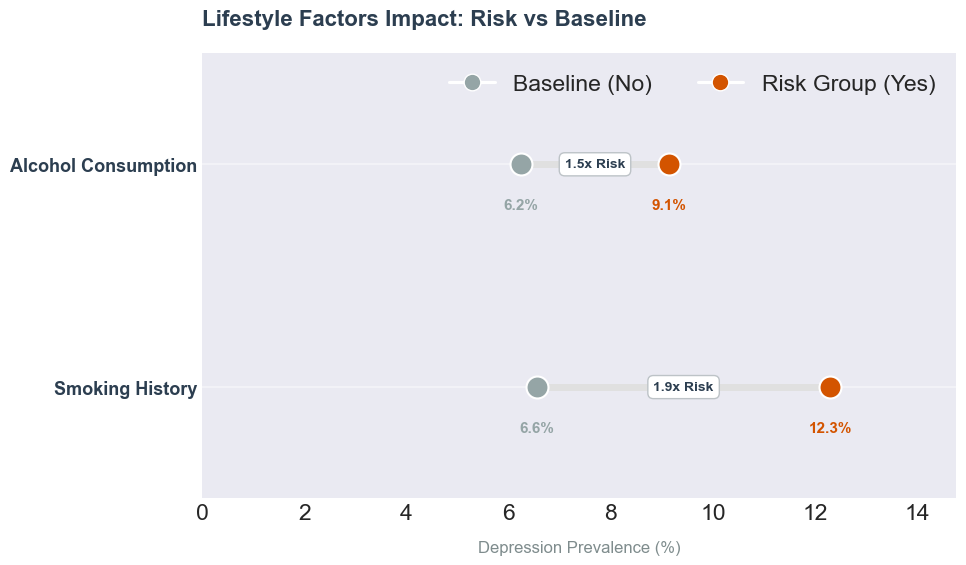

In [76]:
# ==============================================================================
# VISUALIZATION: LIFESTYLE FACTORS (IMPROVED DUMBBELL PLOT)
# ==============================================================================

# 1. Configuration & Data Prep
# ------------------------------------------------------------------------------
# Mapping: Column -> (Label, Risk_Value, Baseline_Value)
factors_config = {
    "100_Cigs_Lifetime": ("Smoking History", 1, 2),  # 1=Yes, 2=No
    "Alcohol_Tried": ("Alcohol Consumption", 1, 2),  # 1=Yes, 2=No
}

# Aesthetics
C_BASE = "#95a5a6"  # Grey for Baseline
C_RISK = "#d35400"  # Burnt Orange for Risk (High contrast)
C_LINE = "#e0e0e0"  # Very light grey for the connection
FONT_COLOR = "#2c3e50"

plot_data = []

# Loop to calculate means
for col, (label, risk_val, base_val) in factors_config.items():
    if col not in df_viz.columns:
        continue

    subset = df_viz[[col, "Depression"]].dropna()

    try:
        # Calculate rates (%)
        r_risk = subset[subset[col] == risk_val]["Depression"].mean() * 100
        r_base = subset[subset[col] == base_val]["Depression"].mean() * 100

        if r_base > 0:
            plot_data.append(
                {
                    "Label": label,
                    "Risk": r_risk,
                    "Base": r_base,
                    "Mult": r_risk / r_base,
                }
            )
    except:
        continue

df_p = pd.DataFrame(plot_data)

# 2. Plotting
# ------------------------------------------------------------------------------
if not df_p.empty:
    # Set figure height based on number of factors to prevent squishing
    fig, ax = plt.subplots(figsize=(10, 3 + len(df_p) * 1.5))

    # Y-positions
    y_range = np.arange(len(df_p))

    for i, row in df_p.iterrows():
        y = y_range[i]

        # A. Connection Line
        ax.hlines(
            y=y, xmin=row["Base"], xmax=row["Risk"], color=C_LINE, linewidth=5, zorder=1
        )

        # B. Baseline Dot (Left)
        ax.scatter(
            row["Base"],
            y,
            s=250,
            color=C_BASE,
            edgecolor="white",
            linewidth=1.5,
            zorder=3,
        )

        # C. Risk Dot (Right)
        ax.scatter(
            row["Risk"],
            y,
            s=250,
            color=C_RISK,
            edgecolor="white",
            linewidth=1.5,
            zorder=3,
        )

        # D. Text Labels (Percent) - Adjusted offsets
        # Base Label (Left of dot or below)
        ax.text(
            row["Base"],
            y - 0.15,
            f"{row['Base']:.1f}%",
            ha="center",
            va="top",
            color=C_BASE,
            fontweight="bold",
            fontsize=11,
        )

        # Risk Label (Right of dot or below)
        ax.text(
            row["Risk"],
            y - 0.15,
            f"{row['Risk']:.1f}%",
            ha="center",
            va="top",
            color=C_RISK,
            fontweight="bold",
            fontsize=11,
        )

        # E. Multiplier Badge (Center)
        # We put it in a box with white background to "cleanly" sit on the line
        mid_x = (row["Base"] + row["Risk"]) / 2
        ax.text(
            mid_x,
            y,
            f"{row['Mult']:.1f}x Risk",
            ha="center",
            va="center",
            color=FONT_COLOR,
            fontsize=10,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#bdc3c7", lw=1),
            zorder=4,
        )

    # 3. Final Formatting
    # ------------------------------------------------------------------------------
    ax.set_yticks(y_range)
    ax.set_yticklabels(df_p["Label"], fontsize=13, fontweight="bold", color=FONT_COLOR)

    # Axis styling
    ax.set_xlabel(
        "Depression Prevalence (%)", fontsize=12, labelpad=12, color="#7f8c8d"
    )

    # Dynamic X-limit to ensure text fits
    max_val = max(df_p["Risk"].max(), df_p["Base"].max())
    ax.set_xlim(0, max_val * 1.2)  # +20% breathing room

    # Add vertical margins
    ax.set_ylim(-0.5, len(df_p) - 0.5)

    # Title
    plt.title(
        "Lifestyle Factors Impact: Risk vs Baseline",
        loc="left",
        fontsize=16,
        fontweight="bold",
        pad=20,
        color=FONT_COLOR,
    )

    # Custom Legend (Clean)
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=C_BASE,
            markersize=12,
            label="Baseline (No)",
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=C_RISK,
            markersize=12,
            label="Risk Group (Yes)",
        ),
    ]
    ax.legend(handles=legend_elements, loc="upper right", frameon=False, ncol=2)

    plt.tight_layout()

    # Save
    try:
        plt.savefig(plots_dir / "lifestyle_Dumbbell.png", dpi=300, bbox_inches="tight")
    except:
        pass

    plt.show()
else:
    print("No data found for lifestyle factors.")

### Feature: Physical Activity (Health Factor)
Bar chart comparing depression rates between active and inactive individuals.


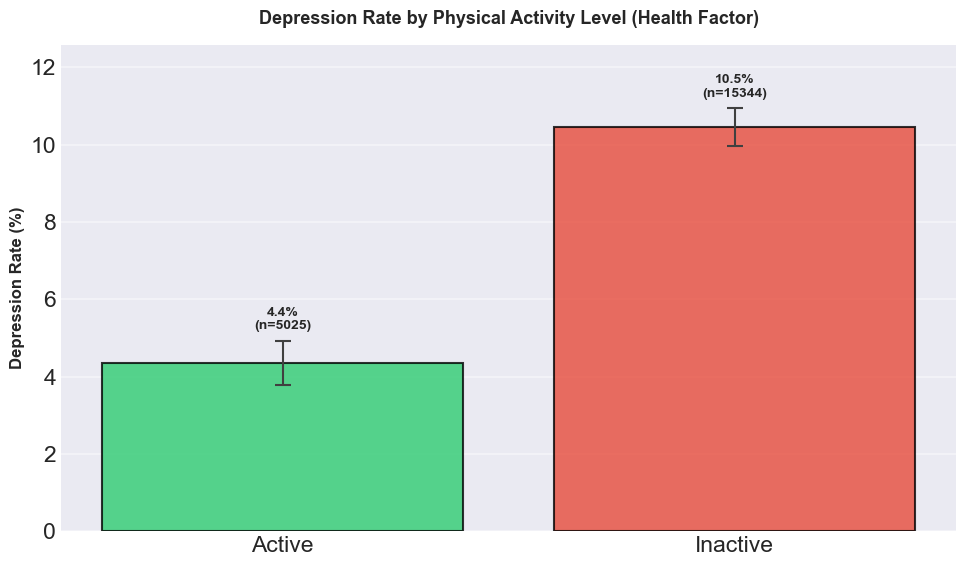

✓ Feature: Physical Activity (Health Factor)


In [77]:
# Feature: Physical Activity (Health Factor)
# Bar chart comparing Active vs Inactive groups

# Data preparation
df_activity = df_viz[["Vigorous_Activity", "Depression"]].dropna()
activity_inactive = df_activity[
    df_activity["Vigorous_Activity"] == 2
]  # Inactive (Risk)
activity_active = df_activity[
    df_activity["Vigorous_Activity"] == 1
]  # Active (Baseline)

# Calculate statistics
if len(activity_inactive) > 0 and len(activity_active) > 0:
    inactive_rate = activity_inactive["Depression"].mean() * 100
    active_rate = activity_active["Depression"].mean() * 100
    inactive_count = len(activity_inactive)
    active_count = len(activity_active)

    # Calculate 95% Confidence Intervals
    inactive_ci = (
        1.96
        * np.sqrt((inactive_rate / 100) * (1 - inactive_rate / 100) / inactive_count)
        * 100
    )
    active_ci = (
        1.96
        * np.sqrt((active_rate / 100) * (1 - active_rate / 100) / active_count)
        * 100
    )

    # Create bar chart
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    categories = ["Active", "Inactive"]
    rates = [active_rate, inactive_rate]
    cis = [active_ci, inactive_ci]
    counts = [active_count, inactive_count]

    # Semantic colors: Green for Active (protective), Red for Inactive (risk)
    colors = ["#2ecc71", "#e74c3c"]  # Green for Active, Red for Inactive

    bars = ax.bar(
        categories,
        rates,
        color=colors,
        alpha=0.8,
        edgecolor="black",
        linewidth=1.5,
        yerr=cis,
        error_kw={
            "elinewidth": 1.5,
            "ecolor": "#404040",
            "capsize": 6,
            "capthick": 1.5,
        },
    )

    # Set labels and title
    ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
    ax.set_title(
        "Depression Rate by Physical Activity Level (Health Factor)",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )

    # Add value labels above error bars
    max_height = max([r + c for r, c in zip(rates, cis)])
    ax.set_ylim(0, max_height * 1.15)

    for i, (bar, count, rate, ci) in enumerate(zip(bars, counts, rates, cis)):
        height = bar.get_height()
        label_y = height + ci + (max_height * 0.02)
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            label_y,
            f"{rate:.1f}%\n(n={count})",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    plt.tight_layout()
    plt.savefig(plots_dir / "physical_Activity.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Feature: Physical Activity (Health Factor)")
else:
    print("⚠ Insufficient data for Physical Activity visualization")


### Feature 5: Education Level


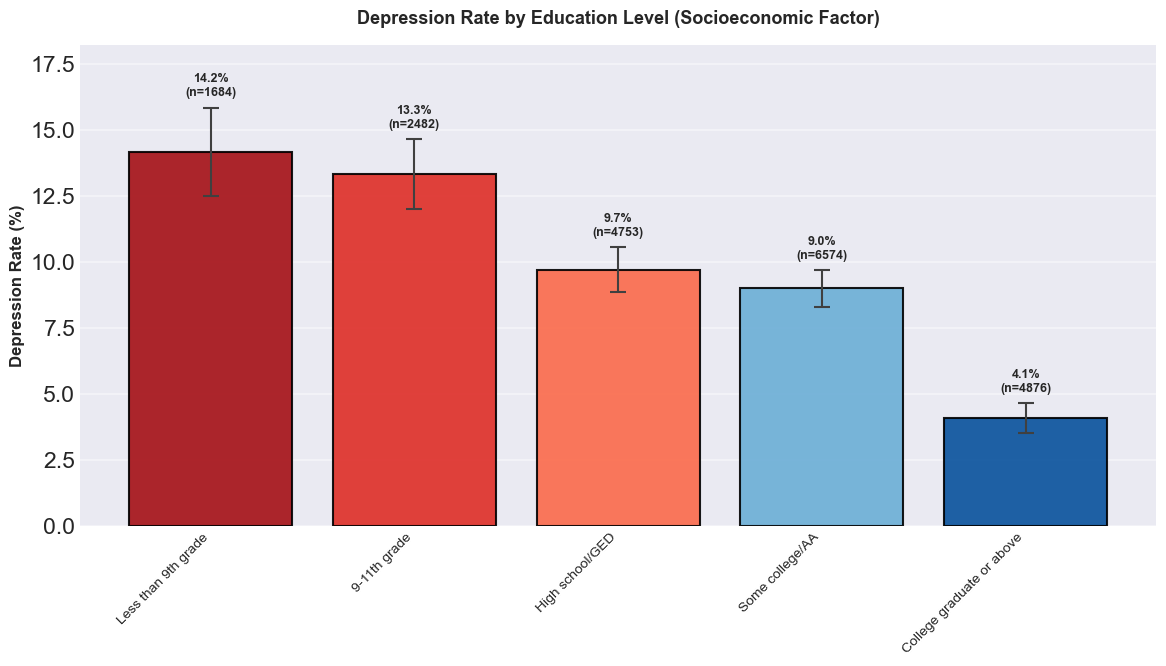

✓ Feature 5: Education Level


In [78]:
# Feature 5: Education Level
df_plot = df_viz[["Education_Level", "Depression"]].dropna()

# Education labels
education_labels = {
    1: "Less than 9th grade",
    2: "9-11th grade",
    3: "High school/GED",
    4: "Some college/AA",
    5: "College graduate or above",
}

# Group data by Education_Level and calculate statistics
edu_depression = (
    df_plot.groupby("Education_Level")
    .agg({"Depression": ["mean", "count"]})
    .reset_index()
)
edu_depression.columns = ["Education_Level", "Depression_Rate", "Count"]
edu_depression["Edu_Label"] = edu_depression["Education_Level"].map(education_labels)

# Calculate 95% Confidence Intervals using standard error formula for proportions
# CI = 1.96 * sqrt(p*(1-p)/n)
edu_depression["CI_95"] = 1.96 * np.sqrt(
    edu_depression["Depression_Rate"]
    * (1 - edu_depression["Depression_Rate"])
    / edu_depression["Count"]
)

# Semantic coloring scheme: High Risk (Red) to Low Risk (Blue)
semantic_colors = {
    1: "#a50f15",  # Deep Red/Burgundy - Highest risk
    2: "#de2d26",  # Muted Red
    3: "#fb6a4a",  # Neutral/Orange
    4: "#6baed6",  # Light Blue
    5: "#08519c",  # Deep Blue - Lowest risk/Protective
}
edu_depression["Color"] = edu_depression["Education_Level"].map(semantic_colors)

# Create single bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Create bars
bars = ax.bar(
    range(len(edu_depression)),
    edu_depression["Depression_Rate"] * 100,
    color=edu_depression["Color"].values,
    alpha=0.9,
    edgecolor="black",
    linewidth=1.5,
)

# Add error bars
ax.errorbar(
    range(len(edu_depression)),
    edu_depression["Depression_Rate"] * 100,
    yerr=edu_depression["CI_95"] * 100,
    fmt="none",
    color="#404040",
    linewidth=1.5,
    capsize=6,
    capthick=1.5,
)

# Set X-axis labels with text labels
ax.set_xticks(range(len(edu_depression)))
ax.set_xticklabels(edu_depression["Edu_Label"], rotation=45, ha="right", fontsize=10)
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Depression Rate by Education Level (Socioeconomic Factor)",
    fontsize=13,
    fontweight="bold",
    pad=15,
)

# Calculate max height for Y-axis limit (rate + CI + padding for labels)
max_height = (
    edu_depression["Depression_Rate"] * 100 + edu_depression["CI_95"] * 100
).max()
ax.set_ylim(0, max_height * 1.15)  # Add 15% padding for labels above error bars


# Add text labels above error bars
for i, (bar, count, rate, ci) in enumerate(
    zip(
        bars,
        edu_depression["Count"],
        edu_depression["Depression_Rate"],
        edu_depression["CI_95"],
    )
):
    height = bar.get_height()
    label_y = (
        height + (ci * 100) + (max_height * 0.02)
    )  # Position above error bar with small gap
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        label_y,
        f"{rate * 100:.1f}%\n(n={count})",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig(plots_dir / "education_Level.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Feature 5: Education Level")


### Feature 6: Race


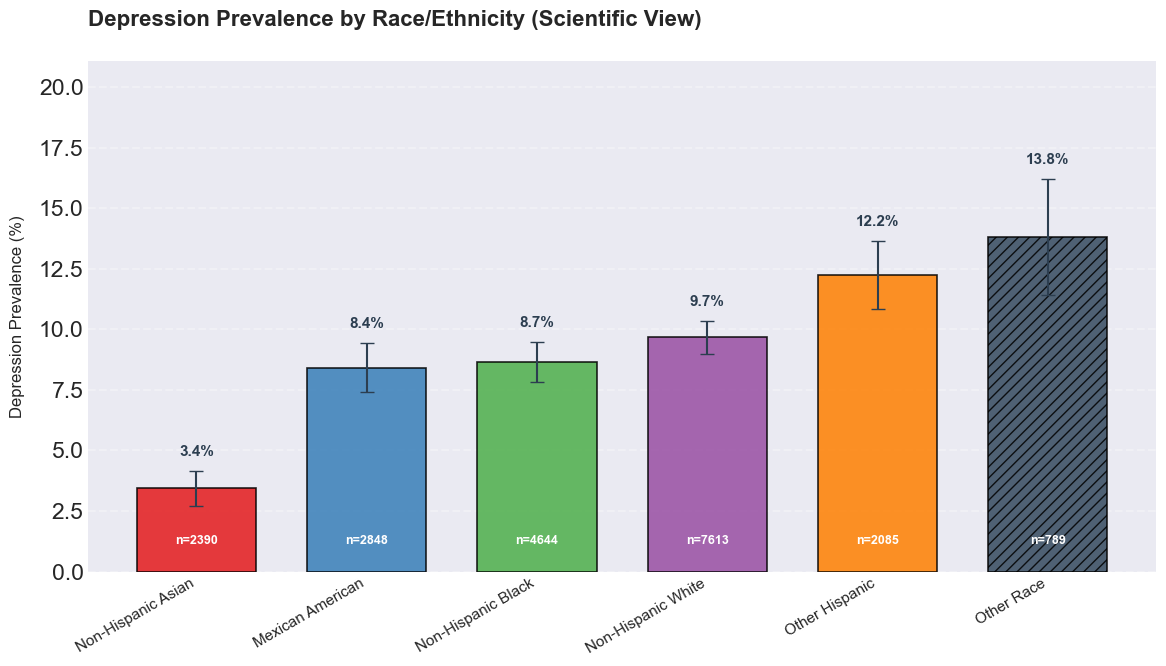

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuration & Data Prep
# ------------------------------------------------------------------------------
race_labels = {
    1: "Mexican American",
    2: "Other Hispanic",
    3: "Non-Hispanic White",
    4: "Non-Hispanic Black",
    6: "Non-Hispanic Asian",
    7: "Other Race",
}

# Prepare Data
df_race = df_viz[["Race", "Depression"]].dropna()

# Groupby stats
race_stats = (
    df_race.groupby("Race")
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Map labels and filter
race_stats["Label"] = race_stats["Race"].map(race_labels)
race_stats = race_stats[race_stats["Count"] >= 10].copy()

# CI Calculation
race_stats["CI"] = 1.96 * np.sqrt(
    race_stats["Mean"] * (1 - race_stats["Mean"]) / race_stats["Count"]
)

# Professional Sorting: Sort by prevalence, but we will identify "Other Race" later
race_stats = race_stats.sort_values("Mean", ascending=True).reset_index(drop=True)

# PROFESSIONAL COLORING LOGIC
# Generate base colors from Set2 for all except the "Other Race"
n_groups = len(race_stats)
palette = sns.color_palette("Set1", n_colors=n_groups).as_hex()

# Identify "Other Race" and apply a specific style
# We find its index in the sorted dataframe
other_color = "#34495e"  # Deep Slate Grey
final_colors = []
for label in race_stats["Label"]:
    if "Other Race" in label:
        final_colors.append(other_color)
    else:
        # Take color from palette
        final_colors.append(palette.pop(0))

race_stats["Color"] = final_colors

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")

bars = ax.bar(
    range(len(race_stats)),
    race_stats["Mean"] * 100,
    color=race_stats["Color"],
    edgecolor="black",
    linewidth=1.2,
    alpha=0.85,
    width=0.7,
    zorder=2,
)

# Apply Hatching to "Other Race" for scientific look
for i, label in enumerate(race_stats["Label"]):
    if "Other Race" in label:
        bars[i].set_hatch("///")  # Professional hatching pattern

# Error Bars
ax.errorbar(
    range(len(race_stats)),
    race_stats["Mean"] * 100,
    yerr=race_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=1.5,
    capsize=5,
    zorder=3,
)

# 3. Formatting & Annotations
# ------------------------------------------------------------------------------
# A. Percentage Labels
for rect, mean, ci in zip(bars, race_stats["Mean"], race_stats["CI"]):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=11,
        color="#2c3e50",
    )

# B. Sample Size (n)
for rect, count in zip(bars, race_stats["Count"]):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        color="white",
        fontsize=9,
        fontweight="bold",
    )

# Axis Setup
ax.set_xticks(range(len(race_stats)))
ax.set_xticklabels(race_stats["Label"], rotation=30, ha="right", fontsize=11)
ax.set_ylabel("Depression Prevalence (%)", fontsize=12, labelpad=10)
ax.set_ylim(0, (race_stats["Mean"].max() * 100 + race_stats["CI"].max() * 100) * 1.3)

# Styling
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)

plt.title(
    "Depression Prevalence by Race/Ethnicity (Scientific View)",
    loc="left",
    pad=25,
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(plots_dir / "race_Ethnicity.png", dpi=300, bbox_inches="tight")
plt.show()

### Feature 7: Poverty Ratio


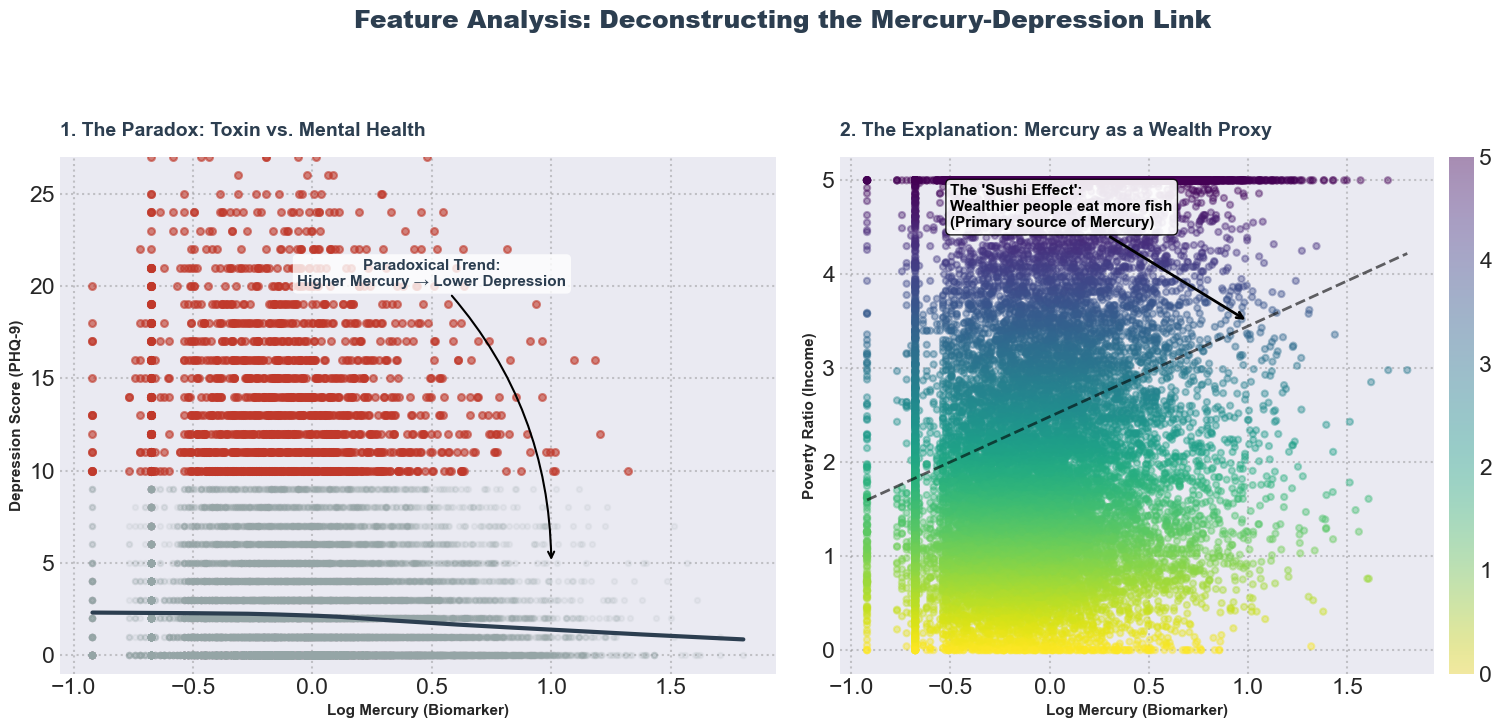

✓ Feature 8: Mercury Paradox (Remastered)


In [80]:
# ==============================================================================
# VISUALIZATION: THE MERCURY PARADOX (REMASTERED)
# ==============================================================================

import matplotlib.patches as patches

# 1. Data Prep & Layering Strategy
# ------------------------------------------------------------------------------
# Filter Data
df_merc = df_viz[["Log_Mercury", "Depression", "PHQ9_Score", "Poverty_Ratio"]].dropna()

# SORT data so 'Depression' points are plotted LAST (on top of grey points)
df_merc = df_merc.sort_values("Depression", ascending=True)

# Define Colors
C_BG = "#ecf0f1"  # Light background for plot area
C_GREY_DOTS = "#95a5a6"  # Non-depressed (noise)
C_RED_DOTS = "#c0392b"  # Depressed (signal)
C_TEAL_LINE = "#16a085"  # Income Line
C_TEXT = "#2c3e50"

# 2. Plotting
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor="white")

# --- PLOT A (LEFT): The Paradox ---
# Strategy: High transparency for noise, solid color for signal.

# 1. Background Dots (No Depression)
axes[0].scatter(
    df_merc[df_merc["Depression"] == 0]["Log_Mercury"],
    df_merc[df_merc["Depression"] == 0]["PHQ9_Score"],
    color=C_GREY_DOTS,
    alpha=0.1,
    s=15,
    label="_nolegend_",
    zorder=1,
)

# 2. Foreground Dots (Depression)
axes[0].scatter(
    df_merc[df_merc["Depression"] == 1]["Log_Mercury"],
    df_merc[df_merc["Depression"] == 1]["PHQ9_Score"],
    color=C_RED_DOTS,
    alpha=0.6,
    s=25,
    label="Depressed Group",
    zorder=2,
)

# 3. Trend Line (Smoothed LOWESS)
sns.regplot(
    data=df_merc,
    x="Log_Mercury",
    y="PHQ9_Score",
    scatter=False,
    lowess=True,
    line_kws={
        "color": "#2c3e50",
        "linewidth": 3,
    },
    ax=axes[0],
)

# 4. Professional Annotation (Arrow instead of Box)
# Pointing to the downward trend at high mercury levels
axes[0].annotate(
    "Paradoxical Trend:\nHigher Mercury \u2192 Lower Depression",
    xy=(1.0, 5),
    xycoords="data",  # Where arrow points
    xytext=(0.5, 20),
    textcoords="data",  # Where text sits
    arrowprops=dict(
        arrowstyle="->", connectionstyle="arc3,rad=-0.2", color="black", lw=1.5
    ),
    fontsize=11,
    fontweight="bold",
    color=C_TEXT,
    ha="center",
    bbox=dict(
        boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8
    ),  # Subtle background for readability
)

axes[0].set_title(
    "1. The Paradox: Toxin vs. Mental Health",
    fontsize=14,
    fontweight="bold",
    loc="left",
    pad=15,
    color=C_TEXT,
)
axes[0].set_ylabel("Depression Score (PHQ-9)", fontsize=11, fontweight="bold")
axes[0].set_xlabel("Log Mercury (Biomarker)", fontsize=11, fontweight="bold")
axes[0].set_ylim(-1, 27)


# --- PLOT B (RIGHT): The Explanation ---
# Strategy: Use Color Mapping to show Wealth visually.

# 1. Scatter with Color Map (Hue = Poverty Ratio)
# This creates a gradient: Darker/Greener points = Richer people
scatter = axes[1].scatter(
    df_merc["Log_Mercury"],
    df_merc["Poverty_Ratio"],
    c=df_merc["Poverty_Ratio"],
    cmap="viridis_r",  # Reverse Viridis (Yellow/Green is wealth)
    alpha=0.4,
    s=20,
    zorder=1,
)

# 2. Trend Line
sns.regplot(
    data=df_merc,
    x="Log_Mercury",
    y="Poverty_Ratio",
    scatter=False,
    ci=None,
    line_kws={"color": "black", "linewidth": 2, "linestyle": "--", "alpha": 0.6},
    ax=axes[1],
)

# 3. Annotation (Arrow)
axes[1].annotate(
    "The 'Sushi Effect':\nWealthier people eat more fish\n(Primary source of Mercury)",
    xy=(1.0, 3.5),
    xycoords="data",
    xytext=(-0.5, 4.5),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", color="#000000", lw=2),
    fontsize=11,
    fontweight="bold",
    color="#000000",
    ha="left",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#000000", lw=1, alpha=0.9),
)

axes[1].set_title(
    "2. The Explanation: Mercury as a Wealth Proxy",
    fontsize=14,
    fontweight="bold",
    loc="left",
    pad=15,
    color=C_TEXT,
)
axes[1].set_ylabel("Poverty Ratio (Income)", fontsize=11, fontweight="bold")
axes[1].set_xlabel("Log Mercury (Biomarker)", fontsize=11, fontweight="bold")

# Add Colorbar for Wealth Context
cbar = plt.colorbar(scatter, ax=axes[1], pad=0.02)

cbar.outline.set_visible(False)


# 3. Global Styling ("Feng Shui")
# ------------------------------------------------------------------------------
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#bdc3c7")
    ax.spines["bottom"].set_color("#bdc3c7")
    ax.grid(True, linestyle=":", alpha=0.4, color="grey", zorder=0)

plt.suptitle(
    "Feature Analysis: Deconstructing the Mercury-Depression Link",
    fontsize=18,
    fontweight="heavy",
    y=1.05,
    color=C_TEXT,
)

plt.tight_layout()

# Save
try:
    plt.savefig(plots_dir / "mercury_Analysis.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 8: Mercury Paradox (Remastered)")

### Feature 9: Gender


  Gender_Label  Mean  Count
0       Female 0.111  10271
1         Male 0.068  10098


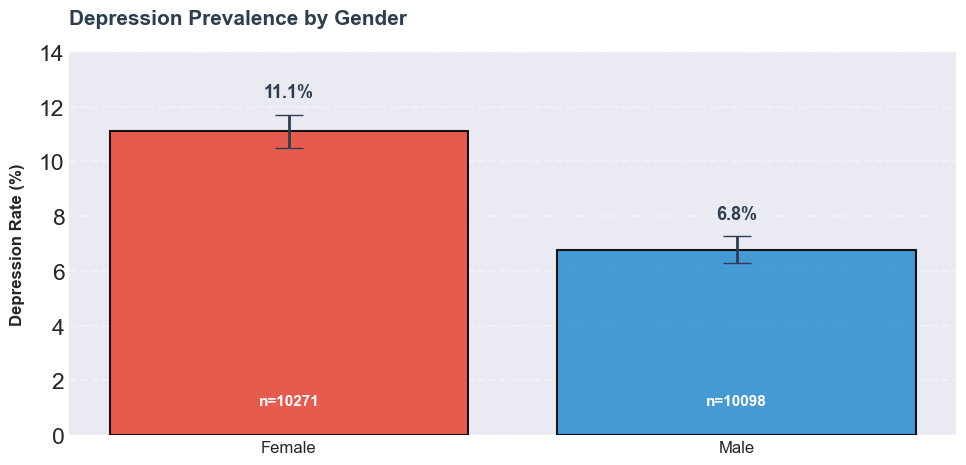

✓ Feature 9: Gender Analysis (Single Chart)


In [81]:
# ==============================================================================
# VISUALIZATION: GENDER ANALYSIS (SINGLE PREVALENCE CHART)
# ==============================================================================

# 1. Data Prep
# ------------------------------------------------------------------------------
# Filter Data
df_gender = df_viz[["Gender", "Depression"]].dropna()

# Map Labels
gender_labels = {1: "Male", 2: "Female"}
df_gender["Gender_Label"] = df_gender["Gender"].map(gender_labels)

# Group Stats
gender_stats = (
    df_gender.groupby("Gender_Label")
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
print("=" * 80)
print(gender_stats)
print("=" * 80)
# print(df_gender.groupby())

# Calculate 95% Confidence Interval
gender_stats["CI"] = 1.96 * np.sqrt(
    gender_stats["Mean"] * (1 - gender_stats["Mean"]) / gender_stats["Count"]
)

# Colors (Semantic)
# Male = Soft Blue, Female = Red/Terracotta (Highlighting higher risk)
colors = {"Male": "#3492D1", "Female": "#E74C3C"}
gender_stats["Color"] = gender_stats["Gender_Label"].map(colors)

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5), facecolor="white")

# Create Bars with Outline
bars = ax.bar(
    gender_stats["Gender_Label"],
    gender_stats["Mean"] * 100,
    color=gender_stats["Color"],
    edgecolor="black",  # Professional outline
    linewidth=1.5,
    width=0.8,
    alpha=0.9,
    zorder=2,
)

# Add Error Bars
ax.errorbar(
    gender_stats["Gender_Label"],
    gender_stats["Mean"] * 100,
    yerr=gender_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2,
    capsize=10,
    zorder=3,
)

# 3. Formatting & Annotations
# ------------------------------------------------------------------------------
# Add Labels (Percent on top, Count inside)
for rect, mean, count, ci in zip(
    bars, gender_stats["Mean"], gender_stats["Count"], gender_stats["CI"]
):
    height = rect.get_height()

    # Percent (Top)
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=13,
        fontweight="bold",
        color="#2c3e50",
    )

    # Count (Inside Bottom)
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="white",
    )

# Axis Styling
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylim(0, 14)  # Set distinct limit
ax.set_title(
    "Depression Prevalence by Gender",
    fontsize=15,
    fontweight="bold",
    loc="left",
    pad=20,
    color="#2c3e50",
)

# Clean Spines ("Feng Shui")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", labelsize=12)

plt.tight_layout()

# Save
try:
    plt.savefig(plots_dir / "gender_Analysis.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 9: Gender Analysis (Single Chart)")

### Feature 10: Age


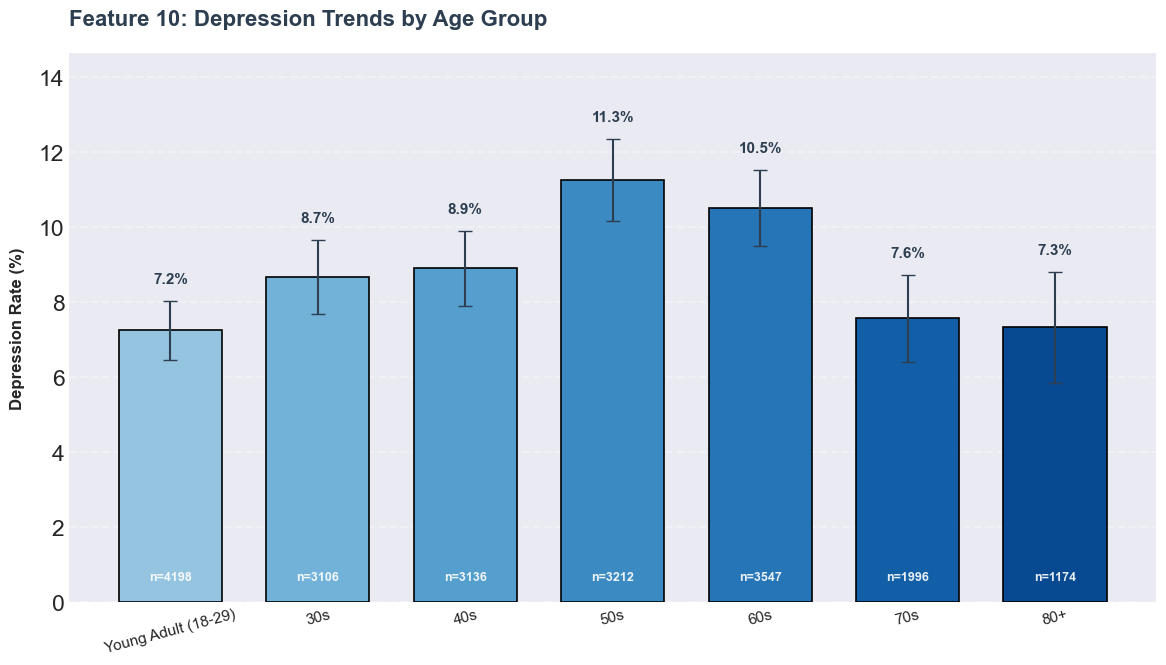

✓ Feature 10: Age Analysis (Optimized)


In [82]:
df_age = df_viz[["Age", "Depression"]].dropna()

# Create Age Bins (Decades)
age_bins = [18, 29, 39, 49, 59, 69, 79, 100]
age_labels = ["Young Adult (18-29)", "30s", "40s", "50s", "60s", "70s", "80+"]

df_age["Age_Group"] = pd.cut(
    df_age["Age"], bins=age_bins, labels=age_labels, include_lowest=True
)

# Group Stats
age_stats = (
    df_age.groupby("Age_Group")
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate 95% CI
age_stats["CI"] = 1.96 * np.sqrt(
    age_stats["Mean"] * (1 - age_stats["Mean"]) / age_stats["Count"]
)

# 2. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")

# A. The Bars (Prevalence)
# Use a sequential colormap (Blues) to represent progression of time
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(age_stats)))

bars = ax.bar(
    range(len(age_stats)),
    age_stats["Mean"] * 100,
    color=colors,
    edgecolor="black",  # Professional outline
    linewidth=1.2,
    width=0.7,
    zorder=2,
)

# B. Error Bars
ax.errorbar(
    range(len(age_stats)),
    age_stats["Mean"] * 100,
    yerr=age_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=1.5,
    capsize=5,
    zorder=3,
)

# 3. Formatting & Annotations
# ------------------------------------------------------------------------------
# Labels
for rect, mean, count, ci in zip(
    bars, age_stats["Mean"], age_stats["Count"], age_stats["CI"]
):
    height = rect.get_height()
    # Percent
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.4,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="#2c3e50",
    )
    # Count (n) - at the bottom of the bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        color="white",
        alpha=0.9,
    )

# Axis Styling
ax.set_xticks(range(len(age_stats)))
ax.set_xticklabels(age_stats["Age_Group"], fontsize=11, fontweight="500", rotation=15)
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylim(0, age_stats["Mean"].max() * 100 * 1.3)  # Give room for labels

# Spines ("Feng Shui")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bdc3c7")
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)
ax.tick_params(axis="y", length=0)

# Title
plt.title(
    "Feature 10: Depression Trends by Age Group",
    fontsize=16,
    fontweight="bold",
    loc="left",
    pad=20,
    color="#2c3e50",
)


plt.tight_layout()

try:
    plt.savefig(plots_dir / "age_Analysis.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 10: Age Analysis (Optimized)")

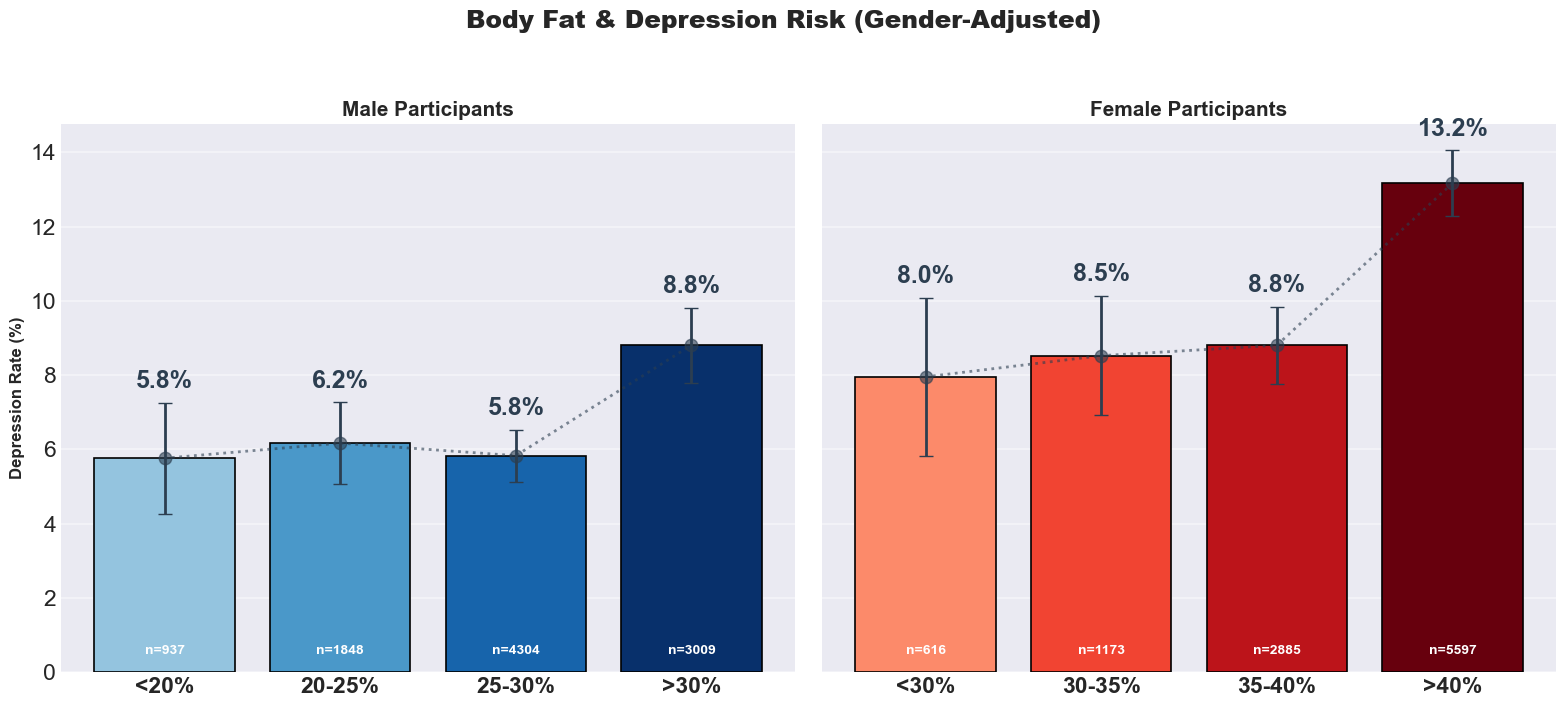

In [83]:
df_fat_base = df_viz[["Body_Fat_Pct", "Depression", "Gender"]].dropna().copy()
df_fat_base["Gender_Label"] = df_fat_base["Gender"].map({1: "Male", 2: "Female"})

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True, facecolor="white")
genders = ["Male", "Female"]

gender_configs = {
    "Male": {
        "bins": [0, 20, 25, 30, 100],
        "labels": ["<20%", "20-25%", "25-30%", ">30%"],
        "palette": plt.cm.Blues(np.linspace(0.4, 1.0, 4)),
    },
    "Female": {
        "bins": [0, 30, 35, 40, 100],
        "labels": ["<30%", "30-35%", "35-40%", ">40%"],
        "palette": plt.cm.Reds(np.linspace(0.4, 1.0, 4)),
    },
}

for i, gender in enumerate(genders):
    ax, config = axes[i], gender_configs[gender]
    subset = df_fat_base[df_fat_base["Gender_Label"] == gender].copy()

    subset["Fat_Group"] = pd.cut(
        subset["Body_Fat_Pct"],
        bins=config["bins"],
        labels=config["labels"],
        include_lowest=True,
    )

    # Aggregate statistics
    stats = (
        subset.groupby("Fat_Group", observed=False)
        .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
        .reset_index()
    )

    # Calculate 95% CI
    stats["CI"] = 1.96 * np.sqrt(
        stats["Mean"] * (1 - stats["Mean"]) / stats["Count"].replace(0, 1)
    )

    # Plot bars and error bars
    x_pos = range(len(stats))
    bars = ax.bar(
        x_pos,
        stats["Mean"] * 100,
        color=config["palette"],
        edgecolor="black",
        linewidth=1.2,
    )

    ax.errorbar(
        x_pos,
        stats["Mean"] * 100,
        yerr=stats["CI"] * 100,
        fmt="none",
        ecolor="#2c3e50",
        elinewidth=2,
        capsize=5,
    )

    ax.plot(
        x_pos,
        stats["Mean"] * 100,
        marker="o",
        color="#2c3e50",
        linewidth=2,
        linestyle=":",
        alpha=0.6,
    )

    # Annotations
    for rect, mean, count, ci in zip(bars, stats["Mean"], stats["Count"], stats["CI"]):
        h = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            h + (ci * 100) + 0.4,
            f"{mean * 100:.1f}%",
            ha="center",
            fontweight="bold",
            color="#2c3e50",
        )
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            0.5,
            f"n={count}",
            ha="center",
            fontsize=10,
            fontweight="bold",
            color="white",
        )

    ax.set_title(f"{gender} Participants", fontsize=15, fontweight="bold")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(config["labels"], fontweight="bold")
    ax.tick_params(left=False)

axes[0].set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
plt.suptitle(
    "Body Fat & Depression Risk (Gender-Adjusted)",
    fontsize=18,
    fontweight="heavy",
    y=1.02,
)
plt.tight_layout()

try:
    plt.savefig(plots_dir / "topbodyfat_Gender.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()

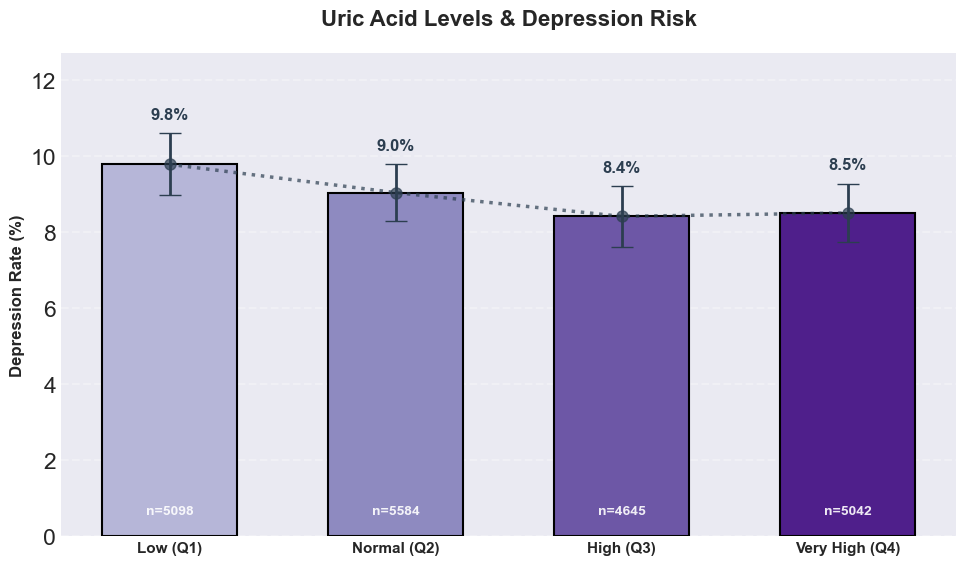

✓ Feature 15: Uric Acid Analysis Generated

🚀 ALL VISUALIZATIONS COMPLETE.


In [84]:
# URIC ACID & DEPRESSION RISK VISUALIZATION
df_ua = df_viz[["UricAcid_mgdL", "Depression"]].dropna()

# Divide population into 4 quartiles
df_ua["UA_Group"] = pd.qcut(
    df_ua["UricAcid_mgdL"],
    q=4,
    labels=["Low (Q1)", "Normal (Q2)", "High (Q3)", "Very High (Q4)"],
)

# Aggregate stats and calculate 95% CI
ua_stats = (
    df_ua.groupby("UA_Group", observed=False)
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
ua_stats["CI"] = 1.96 * np.sqrt(
    ua_stats["Mean"] * (1 - ua_stats["Mean"]) / ua_stats["Count"]
)

# Plotting configuration
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(ua_stats)))

# Bars with error bars and trend line
bars = ax.bar(
    range(len(ua_stats)),
    ua_stats["Mean"] * 100,
    color=colors,
    edgecolor="black",
    linewidth=1.5,
    width=0.6,
    zorder=2,
)
ax.errorbar(
    range(len(ua_stats)),
    ua_stats["Mean"] * 100,
    yerr=ua_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2,
    capsize=8,
    zorder=3,
)
ax.plot(
    range(len(ua_stats)),
    ua_stats["Mean"] * 100,
    marker="o",
    markersize=8,
    color="#2c3e50",
    linewidth=2.5,
    linestyle=":",
    alpha=0.7,
    label="Trend",
)

# Value annotations (Percentages and Sample Sizes)
for rect, mean, count, ci in zip(
    bars, ua_stats["Mean"], ua_stats["Count"], ua_stats["CI"]
):
    height = rect.get_height()
    # Percent above bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.3,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
        color="#2c3e50",
    )
    # Sample size (n) inside bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
        alpha=0.9,
    )

# Formatting
ax.set_xticks(range(len(ua_stats)))
ax.set_xticklabels(ua_stats["UA_Group"], fontsize=11, fontweight="bold")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_ylim(0, ua_stats["Mean"].max() * 100 * 1.3)
ax.spines[["top", "right", "left"]].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)

plt.title("Uric Acid Levels & Depression Risk", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()

# Save and export
try:
    plt.savefig(plots_dir / "uric_Acid.png", dpi=300, bbox_inches="tight")
except:
    pass

plt.show()
print("✓ Feature 15: Uric Acid Analysis Generated")
print("\n" + "=" * 60 + "\n🚀 ALL VISUALIZATIONS COMPLETE.\n" + "=" * 60)

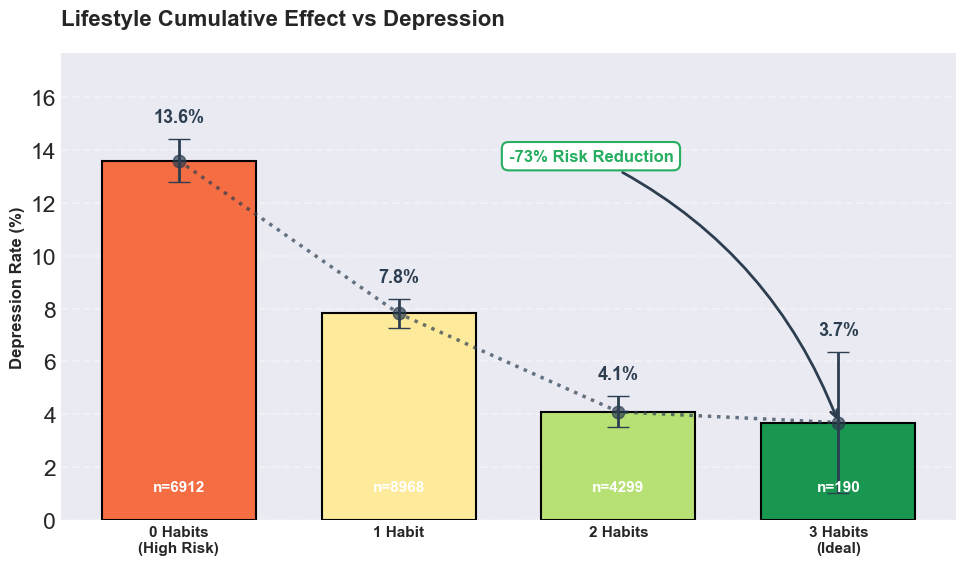

✓ Cumulative Lifestyle Analysis Generated


In [85]:
# Create binary features for Lifestyle Score
df_viz["H_Smoke"] = (df_viz["100_Cigs_Lifetime"] == 2).astype(int)
df_viz["H_Alcohol"] = (df_viz["Alcohol_Tried"] == 2).astype(int)

# Handle physical activity feature with fallback
if "Vigorous_Activity" not in df_viz.columns:
    print("⚠️ 'Phys_Active' not found. Using general health fallback.")
    df_viz["H_Active"] = (df_viz["General_Health_Cond"] <= 2).astype(int)
else:
    df_viz["H_Active"] = (df_viz["Vigorous_Activity"] == 1).astype(int)

df_viz["Lifestyle_Score"] = df_viz["H_Smoke"] + df_viz["H_Alcohol"] + df_viz["H_Active"]

# Calculate statistics and 95% Confidence Interval
life_stats = (
    df_viz.groupby("Lifestyle_Score", observed=False)
    .agg(Mean=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
life_stats["CI"] = 1.96 * np.sqrt(
    life_stats["Mean"] * (1 - life_stats["Mean"]) / life_stats["Count"]
)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(life_stats)))

# Bars and Error Bars
bars = ax.bar(
    life_stats["Lifestyle_Score"],
    life_stats["Mean"] * 100,
    color=colors,
    edgecolor="black",
    linewidth=1.5,
    width=0.7,
    zorder=2,
)
ax.errorbar(
    life_stats["Lifestyle_Score"],
    life_stats["Mean"] * 100,
    yerr=life_stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2,
    capsize=8,
    zorder=3,
)
ax.plot(
    life_stats["Lifestyle_Score"],
    life_stats["Mean"] * 100,
    marker="o",
    color="#2c3e50",
    linewidth=2.5,
    linestyle=":",
    alpha=0.7,
    label="Risk Trend",
)

# Annotations (Percentages and Sample Sizes)
for rect, mean, count, ci in zip(
    bars, life_stats["Mean"], life_stats["Count"], life_stats["CI"]
):
    height = rect.get_height()
    # Percent label
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=13,
        fontweight="bold",
        color="#2c3e50",
    )
    # Sample size (n)
    n_color = "white" if count > 50 else "yellow"
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color=n_color,
    )

# Formatting labels and grid
labels = ["0 Habits\n(High Risk)", "1 Habit", "2 Habits", "3 Habits\n(Ideal)"]
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=11, fontweight="bold")
ax.set_ylabel("Depression Rate (%)", fontsize=12, fontweight="bold")
ax.set_ylim(0, life_stats["Mean"].max() * 100 * 1.3)
ax.spines[["top", "right", "left"]].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.3, zorder=0)

# Risk reduction annotation
try:
    risk_0, risk_3 = life_stats.iloc[0]["Mean"], life_stats.iloc[3]["Mean"]
    drop_pct = (1 - (risk_3 / risk_0)) * 100
    ax.annotate(
        f"-{drop_pct:.0f}% Risk Reduction",
        xy=(3, risk_3 * 100),
        xytext=(1.5, risk_0 * 100),
        arrowprops=dict(
            arrowstyle="->", color="#2c3e50", lw=2, connectionstyle="arc3,rad=-0.2"
        ),
        fontsize=12,
        fontweight="bold",
        color="#27ae60",
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#27ae60"),
    )
except:
    pass

plt.title(
    "Lifestyle Cumulative Effect vs Depression",
    fontsize=16,
    fontweight="bold",
    loc="left",
    pad=20,
)
plt.tight_layout()

# Save and show
try:
    plt.savefig(
        plots_dir / "bonus_Lifestyle_Cumulative.png", dpi=300, bbox_inches="tight"
    )
except:
    pass
plt.show()
print("✓ Cumulative Lifestyle Analysis Generated")

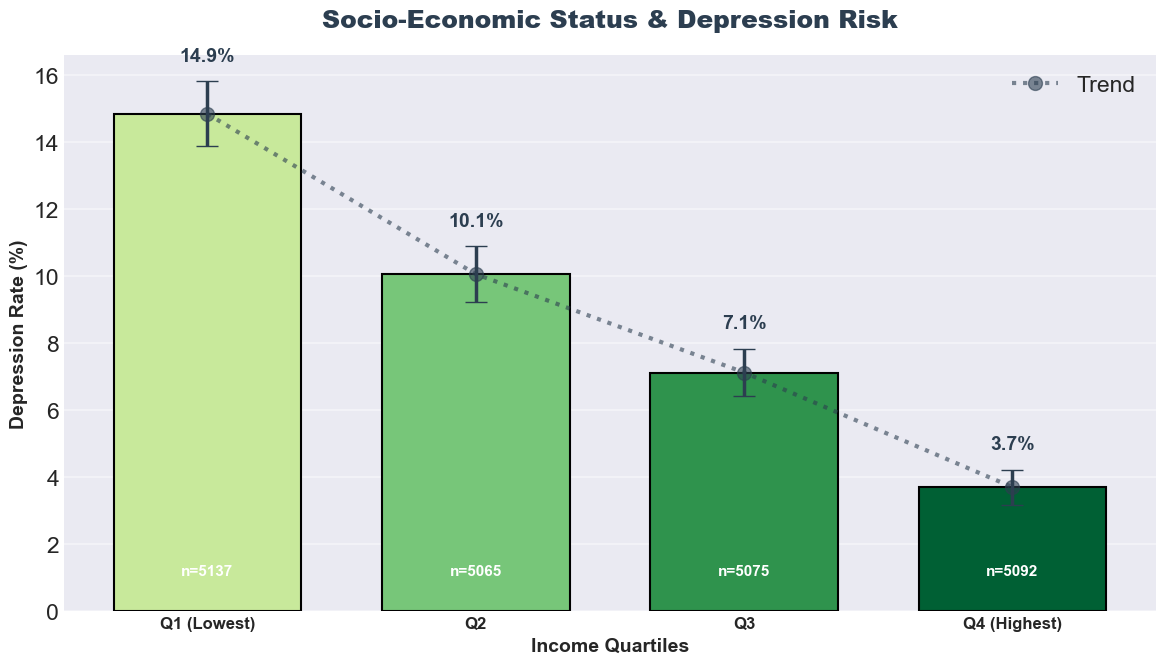

In [86]:
# SES & DEPRESSION RISK VISUALIZATION
wealth_col = "Poverty_Ratio"
target_col = "Depression"

df_wealth = df_viz[[wealth_col, target_col]].dropna().copy()

# Create wealth quartiles (Q1 = Lowest, Q4 = Highest)
try:
    df_wealth["Wealth_Group"] = pd.qcut(
        df_wealth[wealth_col],
        q=4,
        labels=["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"],
    )
except Exception as e:
    print(f"Error creating quartiles: {e}")
    df_wealth["Wealth_Group"] = "Unclassified"

# Aggregate statistics and 95% CI
stats = (
    df_wealth.groupby("Wealth_Group", observed=False)
    .agg(Mean=(target_col, "mean"), Count=(target_col, "count"))
    .reset_index()
)
stats["CI"] = 1.96 * np.sqrt(stats["Mean"] * (1 - stats["Mean"]) / stats["Count"])

# Plotting configuration
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")
palette = plt.cm.YlGn(np.linspace(0.3, 0.9, 4))

# Bar plot with error bars
bars = ax.bar(
    range(len(stats)),
    stats["Mean"] * 100,
    color=palette,
    edgecolor="black",
    linewidth=1.5,
    width=0.7,
    zorder=2,
)
ax.errorbar(
    range(len(stats)),
    stats["Mean"] * 100,
    yerr=stats["CI"] * 100,
    fmt="none",
    ecolor="#2c3e50",
    elinewidth=2.5,
    capsize=8,
    zorder=3,
)

# Social gradient trend line
ax.plot(
    range(len(stats)),
    stats["Mean"] * 100,
    marker="o",
    markersize=10,
    color="#2c3e50",
    linewidth=3,
    linestyle=":",
    alpha=0.6,
    label="Trend",
)

# Value annotations (Percentages and Sample Sizes)
for rect, mean, count, ci in zip(bars, stats["Mean"], stats["Count"], stats["CI"]):
    height = rect.get_height()
    # Percentage above bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + (ci * 100) + 0.5,
        f"{mean * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="#2c3e50",
    )
    # Sample size (n) inside bar
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        1.0,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=11,
        color="white",
        fontweight="bold",
    )

# Labels and Styling
ax.set_title(
    "Socio-Economic Status & Depression Risk",
    fontsize=18,
    fontweight="heavy",
    color="#2c3e50",
    pad=20,
)
ax.set_ylabel("Depression Rate (%)", fontsize=14, fontweight="bold")
ax.set_xlabel("Income Quartiles", fontsize=14, fontweight="bold")
ax.set_xticks(range(len(stats)))
ax.set_xticklabels(stats["Wealth_Group"], fontsize=12, fontweight="bold")
ax.legend()

plt.tight_layout()
plt.savefig(plots_dir / "wealth_Depression_Gradient.png", dpi=300, bbox_inches="tight")
plt.show()

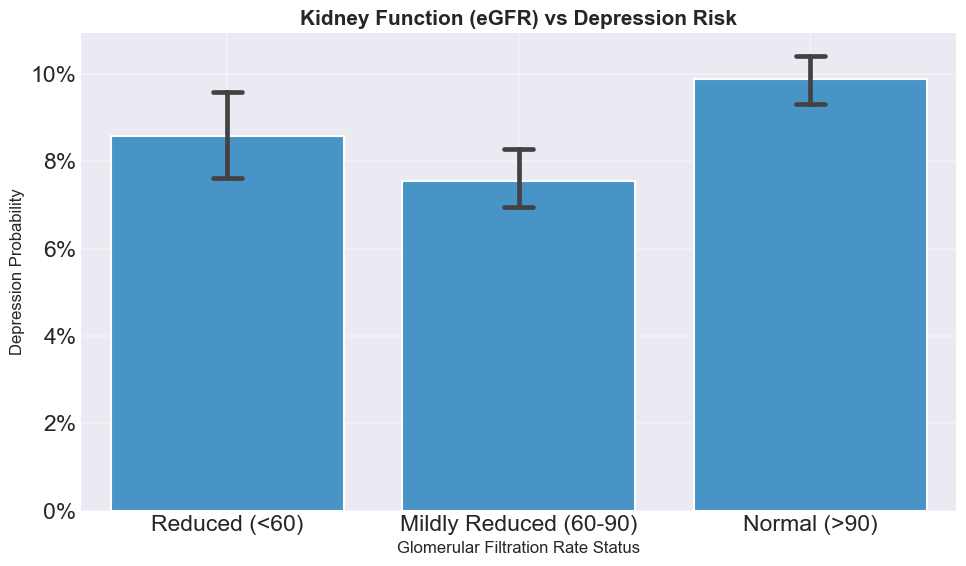

In [87]:
def plot_egfr_depression(df_viz):
    """
    Plots depression prevalence trend across eGFR (Kidney Function) bins.
    """
    if "eGFR" not in df_viz.columns or "Depression" not in df_viz.columns:
        print("Required columns (eGFR, Depression) not found.")
        return

    plt.figure(figsize=(10, 6))

    # Create standard clinically relevant bins for eGFR
    # >90: Normal, 60-90: Mildly Reduced, 45-60: Mod-Severe, 30-45: Severe, <30: Failure
    # We aggregate lower values for statistical significance if needed
    bins = [0, 60, 90, 200]
    labels = ["Reduced (<60)", "Mildly Reduced (60-90)", "Normal (>90)"]

    df_plot = df_viz.copy()
    df_plot["eGFR_Status"] = pd.cut(df_plot["eGFR"], bins=bins, labels=labels)

    # Check for NaN
    if df_plot["eGFR_Status"].isna().any():
        df_plot = df_plot.dropna(subset=["eGFR_Status"])

    ax = sns.barplot(
        x="eGFR_Status", y="Depression", data=df_plot, color="#3498db", capsize=0.1
    )

    plt.title(
        "Kidney Function (eGFR) vs Depression Risk", fontsize=15, fontweight="bold"
    )
    plt.xlabel("Glomerular Filtration Rate Status", fontsize=12)
    plt.ylabel("Depression Probability", fontsize=12)

    # Y-axis formatting
    vals = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(x) for x in vals])

    plt.grid(True, alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()


plot_egfr_depression(df_viz)

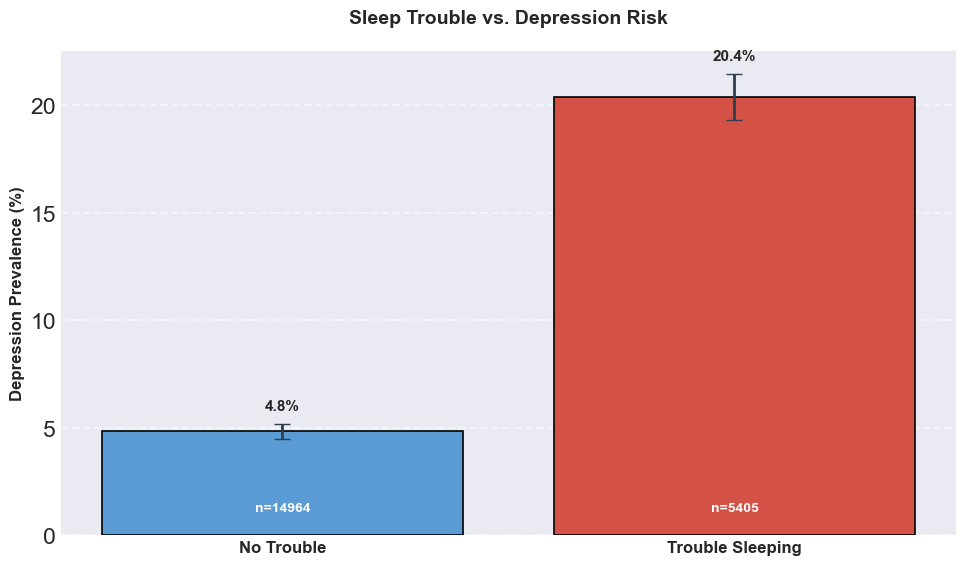

In [88]:
sleep_cols = ["Trouble_Sleeping_Doc", "Depression"]
df_sleep = df_viz[sleep_cols].dropna().copy()

# Map values to human-readable labels
# Assuming 0/2 = No, 1 = Yes based on typical encoding. Adjust if needed.
sleep_labels = {0: "No Trouble", 2: "No Trouble", 1: "Trouble Sleeping"}
df_sleep["Sleep_Label"] = (
    df_sleep["Trouble_Sleeping_Doc"].map(sleep_labels).fillna("Unknown")
)
df_sleep = df_sleep[df_sleep["Sleep_Label"] != "Unknown"]

# 2. Statistical Aggregation
# ------------------------------------------------------------------------------
stats_sleep = (
    df_sleep.groupby("Sleep_Label", observed=False)
    .agg(Rate=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)

# Calculate 95% Confidence Intervals
stats_sleep["CI"] = 1.96 * np.sqrt(
    stats_sleep["Rate"] * (1 - stats_sleep["Rate"]) / stats_sleep["Count"]
)


# 3. Styling Logic
# ------------------------------------------------------------------------------
def get_sleep_color(label):
    if label == "Trouble Sleeping":
        return "#d35145"  # Terracotta Red for risk
    return "#5b9bd5"  # Cornflower Blue for normal


stats_sleep["Color"] = stats_sleep["Sleep_Label"].apply(get_sleep_color)

# 4. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

bars = ax.bar(
    range(len(stats_sleep)),
    stats_sleep["Rate"] * 100,
    color=stats_sleep["Color"],
    edgecolor="black",
    linewidth=1.2,
    yerr=stats_sleep["CI"] * 100,
    error_kw={"elinewidth": 2, "ecolor": "#2c3e50", "capsize": 6},
    zorder=2,
)

ax.set_xticks(range(len(stats_sleep)))
ax.set_xticklabels(stats_sleep["Sleep_Label"], fontsize=12, fontweight="bold")
ax.set_ylabel("Depression Prevalence (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Sleep Trouble vs. Depression Risk", fontsize=14, fontweight="bold", pad=20
)
ax.yaxis.grid(True, linestyle="--", alpha=0.5, zorder=1)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 5. Annotations
# ------------------------------------------------------------------------------
for i, bar in enumerate(bars):
    height = bar.get_height()
    rate = stats_sleep["Rate"].iloc[i] * 100
    count = int(stats_sleep["Count"].iloc[i])
    ci = stats_sleep["CI"].iloc[i] * 100

    # Percent label above
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ci + 0.5,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )
    # N-count label inside
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        1,  # Fixed visual offset from bottom
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.savefig(plots_dir / "Sleep_Trouble", dpi=300, bbox_inches="tight")
plt.show()

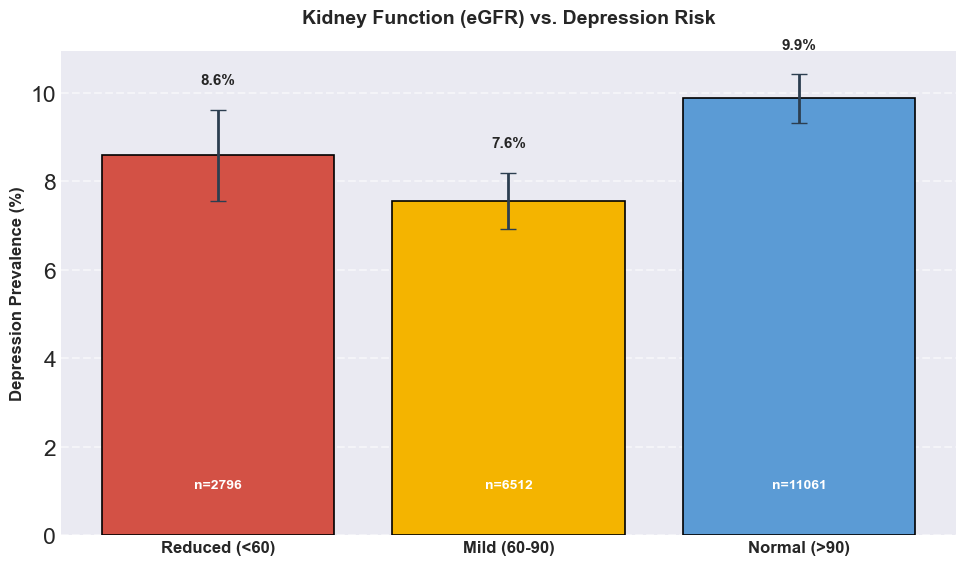

In [89]:
# 1. Data Preparation
# ------------------------------------------------------------------------------
egfr_cols = ["eGFR", "Depression"]
df_egfr = df_viz[egfr_cols].dropna().copy()

# Binning eGFR into clinical categories
# <60: Reduced (Kidney Disease risk), 60-90: Mildly Reduced, >90: Normal
bins = [-1, 60, 90, 300]
labels = ["Reduced (<60)", "Mild (60-90)", "Normal (>90)"]
df_egfr["eGFR_Group"] = pd.cut(df_egfr["eGFR"], bins=bins, labels=labels)

# 2. Statistical Aggregation
# ------------------------------------------------------------------------------
stats_egfr = (
    df_egfr.groupby("eGFR_Group", observed=False)
    .agg(Rate=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
stats_egfr["CI"] = 1.96 * np.sqrt(
    stats_egfr["Rate"] * (1 - stats_egfr["Rate"]) / stats_egfr["Count"]
)


# 3. Styling Logic
# ------------------------------------------------------------------------------
def get_egfr_color(label):
    if "Reduced" in label:
        return "#d35145"  # Red
    elif "Mild" in label:
        return "#f4b400"  # Yellow/Orange
    return "#5b9bd5"  # Blue


stats_egfr["Color"] = stats_egfr["eGFR_Group"].apply(get_egfr_color)

# 4. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

bars = ax.bar(
    range(len(stats_egfr)),
    stats_egfr["Rate"] * 100,
    color=stats_egfr["Color"],
    edgecolor="black",
    linewidth=1.2,
    yerr=stats_egfr["CI"] * 100,
    error_kw={"elinewidth": 2, "ecolor": "#2c3e50", "capsize": 6},
    zorder=2,
)

ax.set_xticks(range(len(stats_egfr)))
ax.set_xticklabels(stats_egfr["eGFR_Group"], fontsize=12, fontweight="bold")
ax.set_ylabel("Depression Prevalence (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Kidney Function (eGFR) vs. Depression Risk", fontsize=14, fontweight="bold", pad=20
)
ax.yaxis.grid(True, linestyle="--", alpha=0.5, zorder=1)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 5. Annotations
# ------------------------------------------------------------------------------
for i, bar in enumerate(bars):
    height = bar.get_height()
    rate = stats_egfr["Rate"].iloc[i] * 100
    count = int(stats_egfr["Count"].iloc[i])
    ci = stats_egfr["CI"].iloc[i] * 100

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ci + 0.5,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        1,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.savefig(plots_dir / "egfr_analysis.png", dpi=300, bbox_inches="tight")
plt.show()


In [90]:
# ==============================================================================
# VISUALIZATION 3: ENERGY INTAKE (KCAL) IMPACT
# ==============================================================================

# 1. Data Preparation
# ------------------------------------------------------------------------------
energy_cols = ["Energy_kcal", "Depression"]
df_energy = df_viz[energy_cols].dropna().copy()
# Filter realistic outliers (e.g., > 6000 kcal might be errors or extreme outliers)
df_energy = df_energy[df_energy["Energy_kcal"] < 6000]

# Binning by Quartiles
df_energy["Energy_Quartile"] = pd.qcut(
    df_energy["Energy_kcal"],
    q=4,
    labels=["Low (Q1)", "Medium (Q2)", "High (Q3)", "Very High (Q4)"],
)

# 2. Statistical Aggregation
# ------------------------------------------------------------------------------
stats_energy = (
    df_energy.groupby("Energy_Quartile", observed=False)
    .agg(Rate=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
stats_energy["CI"] = 1.96 * np.sqrt(
    stats_energy["Rate"] * (1 - stats_energy["Rate"]) / stats_energy["Count"]
)


# 3. Styling Logic
# ------------------------------------------------------------------------------
def get_energy_color(label):
    # Both extremes might be risky, or low energy is risky
    if "Low" in label:
        return "#d35145"  # Red for low intake
    elif "Very High" in label:
        return "#f4b400"  # Orange for very high
    return "#5b9bd5"  # Blue for moderate


stats_energy["Color"] = stats_energy["Energy_Quartile"].apply(get_energy_color)

# 4. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

bars = ax.bar(
    range(len(stats_energy)),
    stats_energy["Rate"] * 100,
    color=stats_energy["Color"],
    edgecolor="black",
    linewidth=1.2,
    yerr=stats_energy["CI"] * 100,
    error_kw={"elinewidth": 2, "ecolor": "#2c3e50", "capsize": 6},
    zorder=2,
)

ax.set_xticks(range(len(stats_energy)))
ax.set_xticklabels(stats_energy["Energy_Quartile"], fontsize=11, fontweight="bold")
ax.set_ylabel("Depression Prevalence (%)", fontsize=12, fontweight="bold")
ax.set_title(
    "Calories Consumption vs. Depression Risk", fontsize=14, fontweight="bold", pad=20
)
ax.yaxis.grid(True, linestyle="--", alpha=0.5, zorder=1)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 5. Annotations
# ------------------------------------------------------------------------------
for i, bar in enumerate(bars):
    height = bar.get_height()
    rate = stats_energy["Rate"].iloc[i] * 100
    count = int(stats_energy["Count"].iloc[i])
    ci = stats_energy["CI"].iloc[i] * 100

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ci + 0.3,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.savefig(plots_dir / "Calorie_Consumption", dpi=300, bbox_inches="tight")
plt.show()

KeyError: "['Energy_kcal'] not in index"

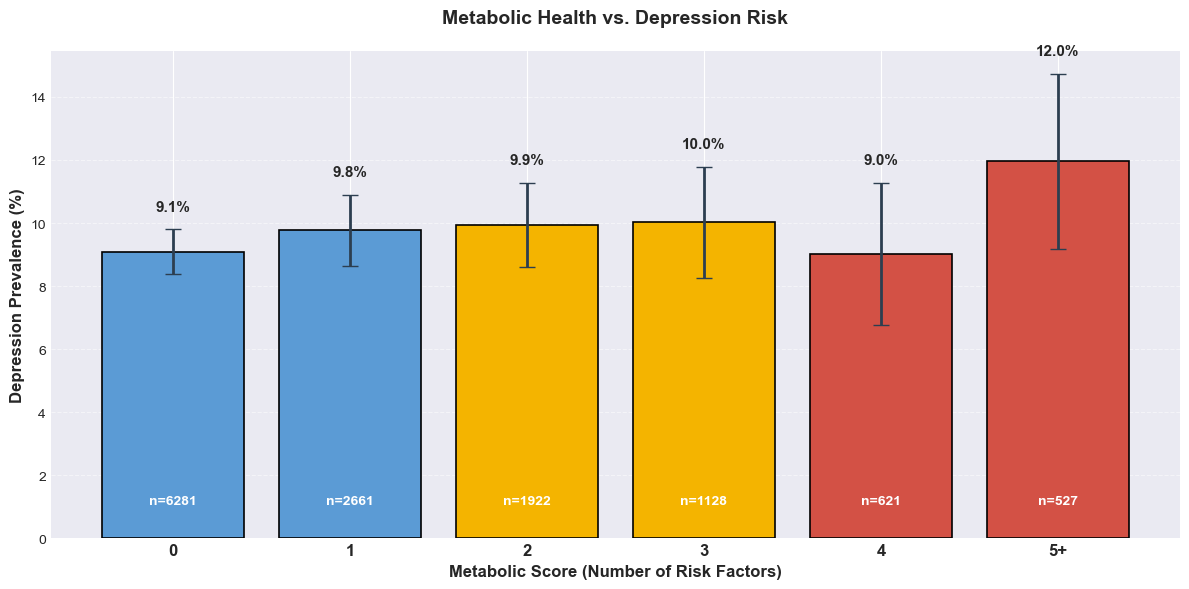

In [ ]:
# 1. Data Preparation
# ------------------------------------------------------------------------------
meta_cols = ["Metabolic_Score", "Depression"]
df_meta = df_viz[meta_cols].dropna().copy()
df_meta["Metabolic_Score"] = df_meta["Metabolic_Score"].astype(int)

# Cap score at 5+ for better visualization if counts are low at extremes
df_meta["Meta_Label"] = df_meta["Metabolic_Score"].apply(
    lambda x: str(x) if x < 5 else "5+"
)

# Ensure proper ordering
labels_order = ["0", "1", "2", "3", "4", "5+"]
df_meta["Meta_Label"] = pd.Categorical(
    df_meta["Meta_Label"], categories=labels_order, ordered=True
)

# 2. Statistical Aggregation
# ------------------------------------------------------------------------------
stats_meta = (
    df_meta.groupby("Meta_Label", observed=False)
    .agg(Rate=("Depression", "mean"), Count=("Depression", "count"))
    .reset_index()
)
stats_meta["CI"] = 1.96 * np.sqrt(
    stats_meta["Rate"] * (1 - stats_meta["Rate"]) / stats_meta["Count"]
)


# 3. Styling Logic
# ------------------------------------------------------------------------------
def get_meta_color(label):
    # Gradient from healthy (0) to unhealthy (5+)
    # 0,1 -> Blue
    # 2,3 -> Orange
    # 4,5+ -> Red
    if label in ["0", "1"]:
        return "#5b9bd5"
    elif label in ["2", "3"]:
        return "#f4b400"
    else:
        return "#d35145"


stats_meta["Color"] = stats_meta["Meta_Label"].apply(get_meta_color)

# 4. Plotting
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

bars = ax.bar(
    range(len(stats_meta)),
    stats_meta["Rate"] * 100,
    color=stats_meta["Color"],
    edgecolor="black",
    linewidth=1.2,
    yerr=stats_meta["CI"] * 100,
    error_kw={"elinewidth": 2, "ecolor": "#2c3e50", "capsize": 6},
    zorder=2,
)

ax.set_xticks(range(len(stats_meta)))
ax.set_xticklabels(stats_meta["Meta_Label"], fontsize=12, fontweight="bold")
ax.set_ylabel("Depression Prevalence (%)", fontsize=12, fontweight="bold")
ax.set_xlabel(
    "Metabolic Score (Number of Risk Factors)", fontsize=12, fontweight="bold"
)
ax.set_title(
    "Metabolic Health vs. Depression Risk", fontsize=14, fontweight="bold", pad=20
)
ax.yaxis.grid(True, linestyle="--", alpha=0.5, zorder=1)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 5. Annotations
# ------------------------------------------------------------------------------
for i, bar in enumerate(bars):
    height = bar.get_height()
    rate = stats_meta["Rate"].iloc[i] * 100
    count = int(stats_meta["Count"].iloc[i])
    ci = stats_meta["CI"].iloc[i] * 100

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ci + 0.5,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        1,
        f"n={count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.savefig(plots_dir / "metabolic_Health.png", dpi=300, bbox_inches="tight")
plt.show()


Loading data...
🚀 Loading Cached Data from C:\Users\Nikita\dev\the\data\processed\nhanes_final_2011_2018.pkl...
   -> Success! Loaded 23578 rows. (Time saved: ~4 mins)


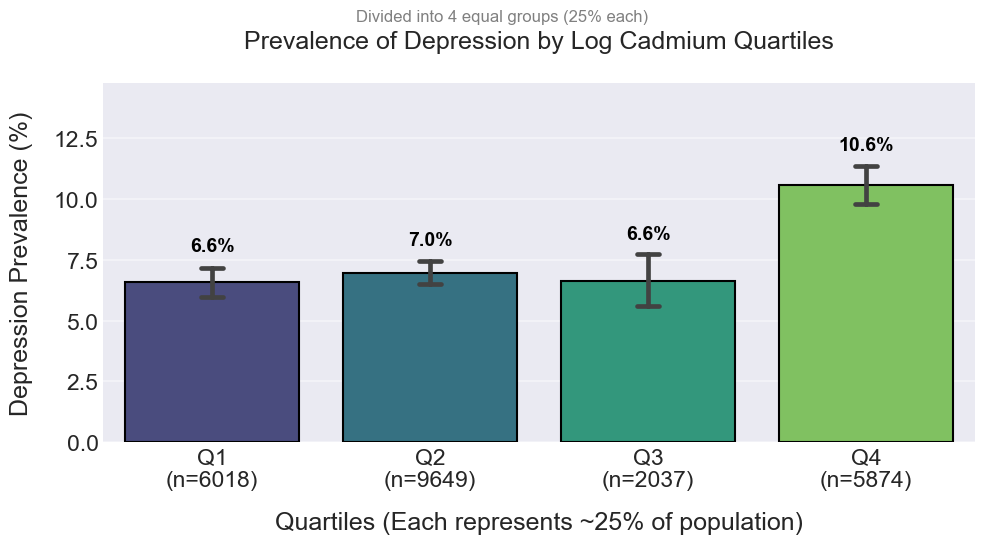

In [93]:
def create_cadmium_chart():
    # Load Data
    print("Loading data...")
    df = load_processed_data(force_reload=False)

    # Variable of interest
    target_var = "Log_Cadmium"
    
    # Check if variable exists
    if target_var not in df.columns:
        print(f"Variable '{target_var}' not found. checking for 'Cadmium_ugL'...")
        if "Cadmium_ugL" in df.columns:
            # Create it on the fly if needed
            df[target_var] = np.log10(df["Cadmium_ugL"] + 0.01)
            print(f"Created {target_var} from Cadmium_ugL")
        else:
             raise ValueError(f"Required columns '{target_var}' or 'Cadmium_ugL' missing from dataset.")

    if "Depression" not in df.columns:
        raise ValueError("Required column 'Depression' missing from dataset.")

    # Drop NaNs
    subset = df.dropna(subset=[target_var, "Depression"]).copy()
    
    # Define Bins (Quartiles)
    # Using duplicates='drop' can sometimes reduce bins if data is very skewed/duplicate
    # But usually for Log_Cadmium it's fine.
    try:
        subset['Bin'] = pd.qcut(subset[target_var], q=4, duplicates='drop')
    except ValueError:
        # Fallback if too many duplicates
        subset['Bin'] = pd.cut(subset[target_var], bins=4)

    # Calculate Label Map (To ensure correct Q1..Q4 labeling on raw data)
    stats = subset.groupby('Bin')['Depression'].agg(['count', 'mean', 'sem']).reset_index()
    stats['Label'] = [f"Q{i+1}\n(n={r['count']})" for i, r in stats.iterrows()]
    
    # Map Bin -> Label
    bin_to_label = dict(zip(stats['Bin'], stats['Label']))
    subset['Label'] = subset['Bin'].map(bin_to_label)
    
    # Convert Depression to Percentage
    subset['Depression_Pct'] = subset['Depression'] * 100

    # Sort stats
    stats = stats.sort_values(by='Bin')
    
    # Create Bar Chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=subset,      
        x="Label",
        y="Depression_Pct",
        palette="viridis",
        edgecolor="black",
        linewidth=1.5,
        errorbar=('ci', 95), 
        capsize=0.1          
    )

    # Customize Plot
    ax.set_title("Prevalence of Depression by Log Cadmium Quartiles", pad=25, fontsize=18)
    
    # --- CHANGED: X-Axis Label explicitly mentions 25% ---
    ax.set_xlabel("Quartiles (Each represents ~25% of population)", labelpad=15, fontweight='medium')
    # -----------------------------------------------------
    
    ax.set_ylabel("Depression Prevalence (%)", labelpad=15)
    
    # Manually place labels ABOVE the whiskers
    upper_bounds = (stats['mean'] + 1.96 * stats['sem']) * 100
    means = stats['mean'] * 100
    
    # Add labels
    for i, (mean, upper) in enumerate(zip(means, upper_bounds)):
        text_y = upper + 0.5 
        ax.text(
            x=i, 
            y=text_y, 
            s=f"{mean:.1f}%", 
            ha='center', 
            va='bottom', 
            fontsize=14, 
            fontweight='bold', 
            color='black'
        )

    ax.set_ylim(0, upper_bounds.max() * 1.3) 

    # Add subtitle about 25% if needed, but xlabel covers it.
    plt.suptitle("Divided into 4 equal groups (25% each)", fontsize=12, y=0.92, color='gray')

    # Save Plot
    output_path = project_root / "plots" / "cadmium_depression_quartiles.png"
    output_path.parent.mkdir(exist_ok=True)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.savefig(plots_dir / "cadmium_depression_quartiles.png", dpi=300,bbox_inches="tight")

if __name__ == "__main__":
    create_cadmium_chart()

Loading data...
🚀 Loading Cached Data from C:\Users\Nikita\dev\the\data\processed\nhanes_final_2011_2018.pkl...
   -> Success! Loaded 23578 rows. (Time saved: ~4 mins)


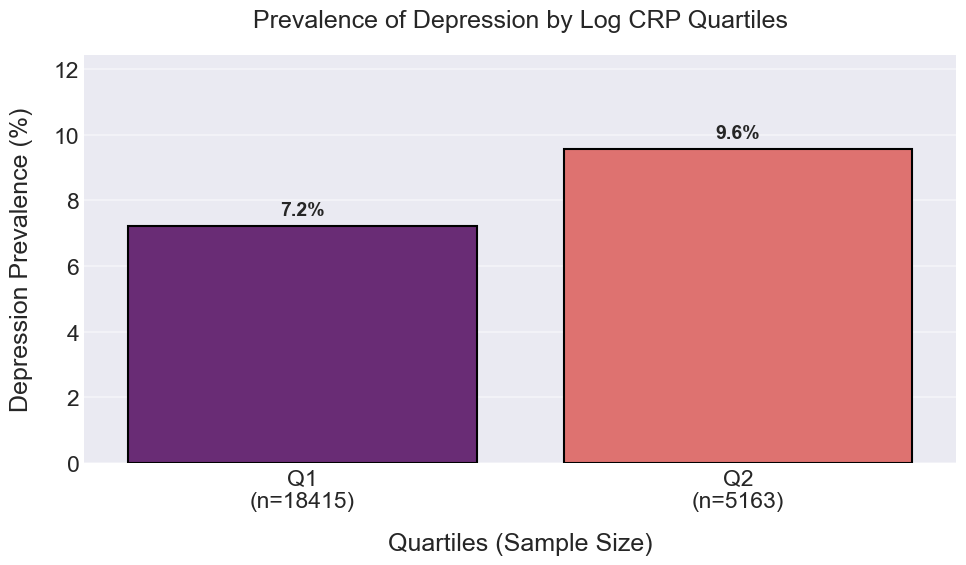

In [ ]:


def create_crp_chart():
    # Load Data
    print("Loading data...")
    df = load_processed_data(force_reload=False)

    # Variable of interest
    target_var = "Log_CRP" # Assuming this was created in preprocessing
    
    # Check if variable exists
    if target_var not in df.columns:
        print(f"Variable '{target_var}' not found. checking for 'CRP_mgL'...")
        if "CRP_mgL" in df.columns:
            # Create it on the fly if needed
            df[target_var] = np.log10(df["CRP_mgL"] + 0.01)
            print(f"Created {target_var} from CRP_mgL")
        else:
             raise ValueError(f"Required columns '{target_var}' or 'CRP_mgL' missing from dataset.")

    if "Depression" not in df.columns:
        raise ValueError("Required column 'Depression' missing from dataset.")

    # Drop NaNs
    subset = df.dropna(subset=[target_var, "Depression"]).copy()
    
    # Define Bins (Quartiles)
    # Using q=4 for Q1-Q4
    subset['Bin'] = pd.qcut(subset[target_var], q=4, duplicates='drop')
    
    # Calculate Statistics per Bin
    stats = subset.groupby('Bin')['Depression'].agg(['mean', 'count']).reset_index()
    stats['Percentage'] = stats['mean'] * 100

    # Create Custom Labels (Q1 - Q4)
    stats['Label'] = [f"Q{i+1}\n(n={r['count']})" for i, r in stats.iterrows()]

    # Create Bar Chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=stats,
        x="Label",
        y="Percentage",
        palette="magma",   # <--- DIFFERENT PALETTE (magma or rocket or flare)
        edgecolor="black", # <--- OUTLINE
        linewidth=1.5      # <--- OUTLINE THICKNESS
    )

    # Customize Plot
    ax.set_title("Prevalence of Depression by Log CRP Quartiles", pad=20, fontsize=18)
    ax.set_xlabel("Quartiles (Sample Size)", labelpad=15)
    ax.set_ylabel("Depression Prevalence (%)", labelpad=15)
    ax.set_ylim(0, stats['Percentage'].max() * 1.3) 

    # Add value labels
    for i in ax.containers:
        ax.bar_label(i, fmt="%.1f%%", padding=5, fontsize=14, fontweight='bold')

    # Save Plot
    output_path = project_root / "plots" / "crp_depression_quartiles.png"
    output_path.parent.mkdir(exist_ok=True)

    plt.tight_layout()
    plt.savefig(plots_dir / "crp_depression_quartiles.png", dpi=300,bbox_inches="tight")
    

if __name__ == "__main__":
    create_crp_chart()
